In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%config InlineBackend.figure_format = 'retina'

In [3]:
products_cats = pd.read_csv('../../SFS/environmental_impacts/Products_dat/products_categories.csv')

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
products_cats.shape

(1154551, 37)

In [5]:
products_cats[products_cats['ingredients_text'].notnull()].shape

(853335, 37)

In [6]:
products_cats[products_cats['ingredients_text'].notnull()]['country'].nunique()

76

In [7]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Total_Impacts_By_Product_sourcing*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

impacts = pd.concat(df_list, axis=0, ignore_index=True)

In [8]:
impacts = products_cats.merge(impacts.drop('product_name', axis=1), left_on='product_id', 
                              right_on='id').drop('id', axis=1)

In [9]:
impacts.shape

(789840, 130)

In [10]:
preds = []

for prefix in ['eng/', 'non_eng/']:
    pred = pd.read_csv(f'../../SFS/openfoodfacts/all/predictions/{prefix}predictions_nn.csv')

    # pred = pred[(pred['parentcategory_prob']>0.8)
    #                   & ((pred['subfoodgroup_prob'].isna()) | (pred['subfoodgroup_prob']>0.8))]
    
    preds.append(pred)

off = pd.concat(preds, axis=0, ignore_index=True)
fdb = pd.read_csv('../../SFS/NDNS UK/predictions/all_predictions_15Oct2024.csv').drop('product_name', axis=1).rename(columns={
    'product_list_name': 'product_name',
    'parentcategory_pred': 'parentcategory', 
    'mainfoodgroup_pred': 'mainfoodgroup', 
    'subfoodgroup_pred': 'subfoodgroup'
    })

cols = ['product_id', 'product_name', 'ingredients_text', 'parentcategory', 'mainfoodgroup', 'subfoodgroup',
        'parentcategory_prob', 'subfoodgroup_prob']
categories = pd.concat([off, fdb], axis=0, ignore_index=True)
categories = categories[cols]

In [11]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Outputs', "*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

composition = pd.concat(df_list, axis=0, ignore_index=True)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,9,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
composition['percent'] = pd.to_numeric(composition['percent'], errors='coerce')

In [13]:
comp_75 = composition[(composition['id'].isin(impacts['product_id'].unique()))]
comp_75 = comp_75[(comp_75['Food_Category'].isna())
                 & (comp_75['Food_Category_sub'].isna())
                 & (comp_75['Food_Category_sub_sub'].isna())]
comp_75 = comp_75.groupby('id')[['percent']].sum().reset_index()
impacts = impacts[~impacts['product_id'].isin(comp_75[comp_75['percent']>25]['id'].unique())].reset_index(drop=True)

In [14]:
# 2 products have empty product names, removing them
impacts = impacts[impacts['product_name'].notnull()]
# removing duplicated product names
impacts = impacts.drop_duplicates(subset=['product_name', 
                                          # 'ingredients_text', 
                                          'country'])

In [15]:
impacts.shape

(503575, 130)

In [16]:
cat_map = pd.read_csv('../../SFS/environmental_impacts/Products_dat/cat_map.csv')

In [17]:
impacts = impacts.merge(cat_map)

In [18]:
# split dairy and dairy alternatives

ids = impacts[impacts['Department'].isin(['Milk and Milk Products'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]
milk_ids = composition_sub[composition_sub['Food_Category'].isin(['Milk', 'Cheese', 'Butter, Cream & Ghee'])]['id'].unique()
vegan_milk_ids = set(composition_sub[(composition_sub['Food_Category'].isin([
    'Other Fruit', 'Nuts','Other Pulses', 'Oatmeal', 'Rice']))]['id'].unique()).difference(set(milk_ids))
vegan_milk_ids = vegan_milk_ids.difference(composition_sub[(composition_sub['Food_Category'].isin([
    'Eggs', 'Fish (farmed)',
    'Lamb & Mutton', 'Bovine Meat (dairy herd)',
    'Milk Chocolate', 'Bovine Meat (beef herd)']))]['id'].unique())

impacts.loc[impacts['product_id'].isin(vegan_milk_ids), 'labels'] = 'Milk alternatives'
impacts.loc[impacts['product_id'].isin(vegan_milk_ids), 'ID'] = '2G'

impacts.loc[(impacts['product_id'].isin(ids))
           & (~impacts['product_id'].isin(vegan_milk_ids))
           & (~impacts['product_id'].isin(milk_ids)), 'labels'] = 'mis'

In [19]:
# meat alternatives 

veg_meat_ids = impacts[impacts['labels']=='Meat alternatives']['product_id'].unique()
composition_sub = composition[composition['id'].isin(veg_meat_ids)]

id_pig = composition_sub[composition_sub['Food_Category'].isin([
    'Pig Meat'
])]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_pig), 'labels'] = 'Pig meat'
impacts.loc[impacts['product_id'].isin(id_pig), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_pig), 'ID'] = '3D'

id_poultry = composition_sub[(~composition_sub['product_name'].str.lower().str.contains('linda mccartney')) & (composition_sub['Food_Category'].isin([
    'Poultry Meat'
]))]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_poultry), 'labels'] = 'Poultry meat'
impacts.loc[impacts['product_id'].isin(id_poultry), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_poultry), 'ID'] = '3C'

id_beef = composition_sub[composition_sub['Food_Category'].isin([
    'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)'
])]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_beef), 'labels'] = 'Beef'
impacts.loc[impacts['product_id'].isin(id_beef), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_beef), 'ID'] = '3E'

id_lamb = composition_sub[composition_sub['Food_Category'].isin([
    'Lamb & Mutton'
])]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_lamb), 'labels'] = 'Lamb'
impacts.loc[impacts['product_id'].isin(id_lamb), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_lamb), 'ID'] = '3F'

In [20]:
# split meat with meat dishes

# Chicken and turkey
ids = impacts[impacts['labels']=='Chicken and turkey']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin(['Poultry Meat'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin(['Poultry Meat'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


# Beef
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'Department'] = 'Meat and Meat Products'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'Aisle'] = 'Beef, veal and dishes'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'Shelf'] = 'Beef and veal'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'labels'] = 'Beef'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'ID'] = '3E'
ids = impacts[impacts['labels']=='Beef']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin([
    'Bovine Meat (dairy herd)','Bovine Meat (beef herd)'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin([
    'Bovine Meat (dairy herd)','Bovine Meat (beef herd)'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


# Burgers and kebabs
# Other meat products
# Sausages

# Pig meat
ids = impacts[impacts['labels']=='Pork']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin(['Pig Meat'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin(['Pig Meat'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


# Meat pies and pastries
# Other meat products
              
# Lamb 
ids = impacts[impacts['labels']=='Lamb']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin(['Lamb & Mutton'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin(['Lamb & Mutton'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


In [21]:
impacts[impacts['labels']=='mis'].shape

(4113, 133)

In [22]:
impacts[impacts['labels']!='mis']['country'].nunique()

74

In [23]:
impacts[impacts['labels']!='mis'].shape

(499462, 133)

In [24]:
impacts[impacts['labels']!='mis']['country'].value_counts()

United States           146518
United Kingdom          122563
France                   97455
Germany                  26654
Spain                    14068
Switzerland              11524
Italy                     8895
Belgium                   8522
Canada                    6596
Australia                 5212
Netherlands               5100
Poland                    3401
Ireland                   3042
Mexico                    2340
Austria                   2249
Sweden                    2221
New Zealand               1937
Czech Republic            1905
Finland                   1873
Portugal                  1857
Bulgaria                  1797
Norway                    1770
Romania                   1510
Bolivia                   1503
Argentina                 1231
Russia                    1223
India                     1196
Brazil                    1167
Thailand                  1014
Hungary                    952
Croatia                    911
Luxembourg                 797
Denmark 

In [25]:
set(products_cats['country'].unique()).difference(set(impacts['country'].unique()))

{'Serbia', 'South Africa'}

#### not normalized - raw scores

In [26]:
score_columns = ['Land', 
                 'GHG', 
                 'Eut', 
                 'WatScar',
                 'Biodiversity', 
                 # 'Acidification', 
                 # 'WaterUse'
                ]

In [27]:
# Melt the aggregated dataframe to long format for seaborn
melted_df = impacts.melt(
    id_vars=['country', 'groups', 'labels', 'ID', 'product_id'],
    value_vars=[f"mean_{score}" for score in score_columns],
    var_name='score',
    value_name='mean'
)

# Extract the score name
melted_df['score'] = melted_df['score'].str.replace('_mean', '')
melted_df['score'] = melted_df['score'].str.replace('mean_', '')

In [28]:
df_plot = melted_df[melted_df['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot = df_plot[df_plot['labels']!='mis']

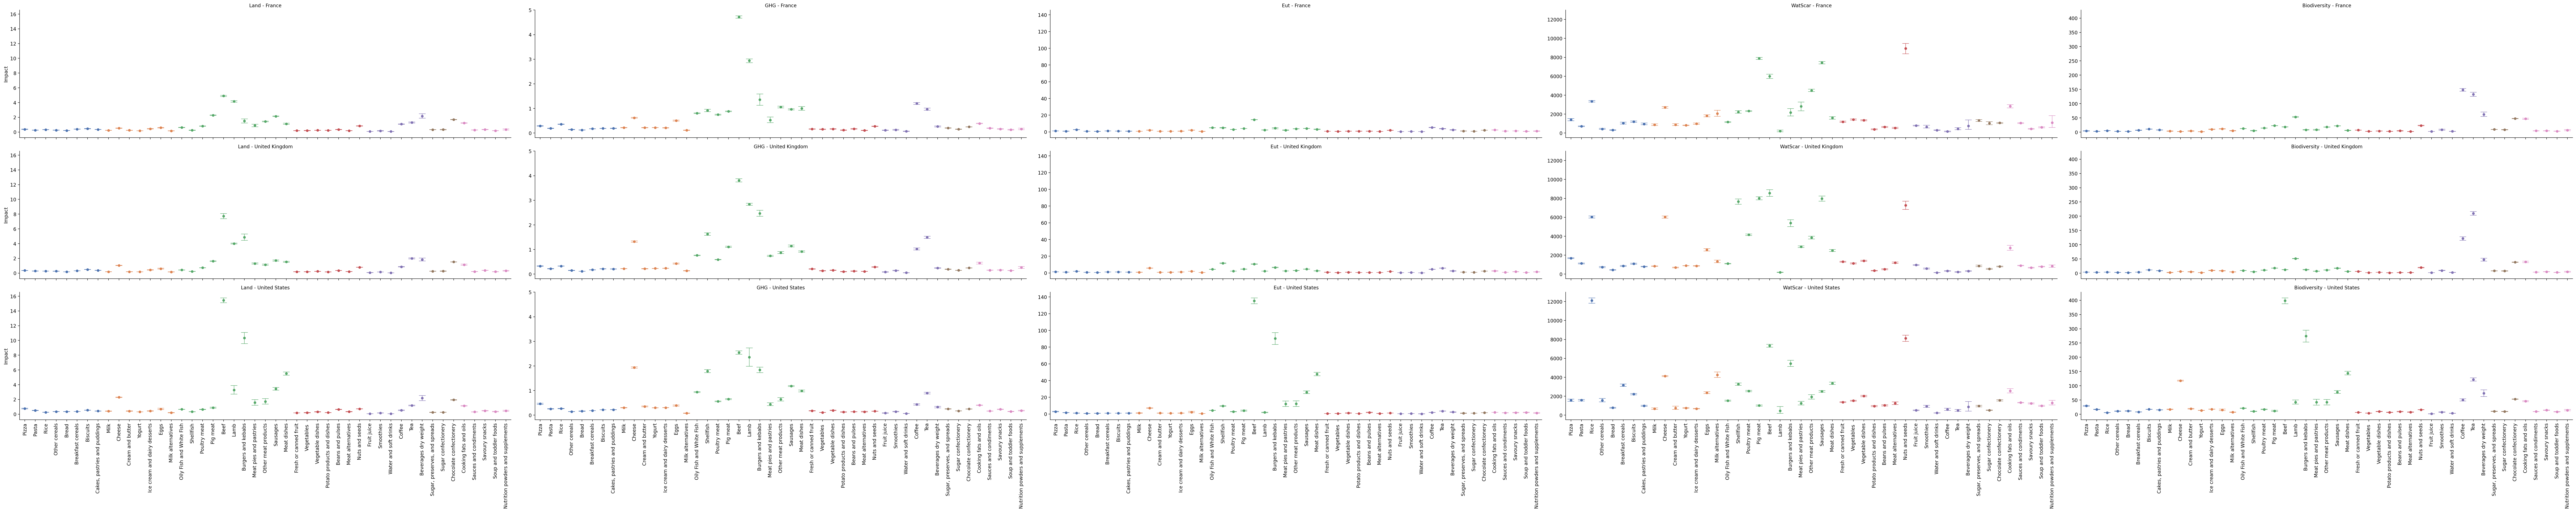

In [30]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  row='country', 
                  col='score', 
                  sharey='col',
                  row_order=['France', 'United Kingdom', 'United States'],
                  height=5, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean', 
        hue='groups',
        data=data.sort_values(by=['ID']), 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8, 
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Impact")
g.set_titles("{col_name} - {row_name}")

plt.tight_layout()
plt.show()


#### normalized but not aggregated

In [33]:
def get_norm(g):
    g['mean_norm'] = 100 * (g['mean'] - g['mean'].min()) / (g['mean'].max() - g['mean'].min())
    return g

In [34]:
melted_df = melted_df.groupby('score').apply(lambda g: get_norm(g)).reset_index(drop=True)

In [35]:
df_plot = melted_df[melted_df['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot = df_plot[df_plot['labels']!='mis']

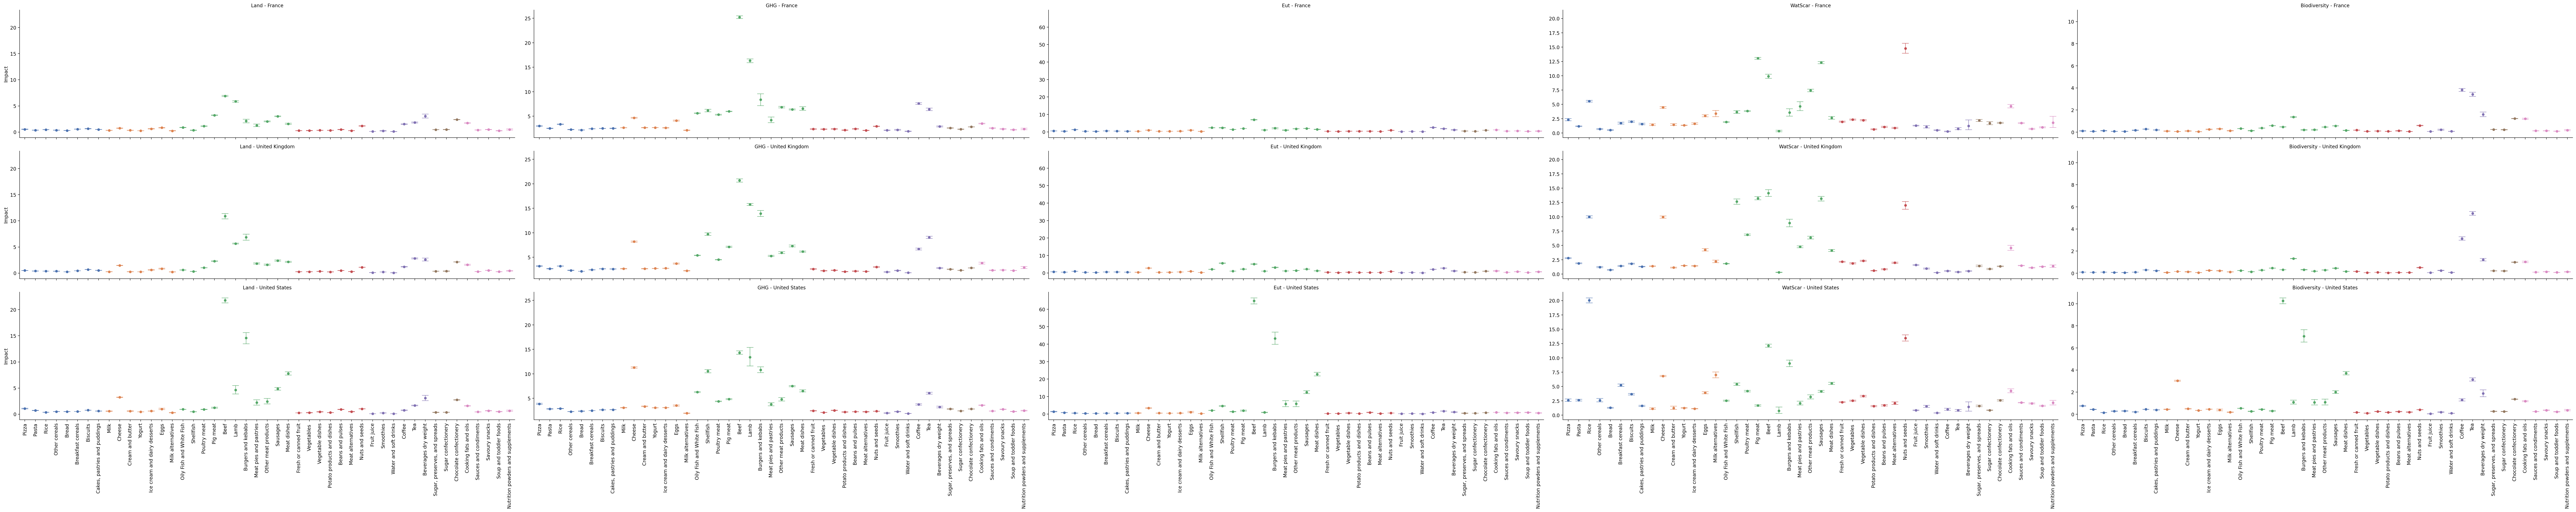

In [37]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  row='country', 
                  col='score', 
                  sharey='col',
                  row_order=['France', 'United Kingdom', 'United States'],
                  height=5, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean_norm', 
        hue='groups',
        data=data.sort_values(by=['ID']), 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8,  
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Impact")
g.set_titles("{col_name} - {row_name}")

plt.tight_layout()
plt.show()


#### normalized and aggregated

In [38]:
melted_df = melted_df.groupby(['country', 'groups', 'labels', 'ID', 'product_id'])[['mean_norm']].mean().reset_index()

In [39]:
df_plot = melted_df[melted_df['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot = df_plot[df_plot['labels']!='mis']

In [40]:
df_mapping = df_plot[['groups', 'labels', 'ID']].drop_duplicates()

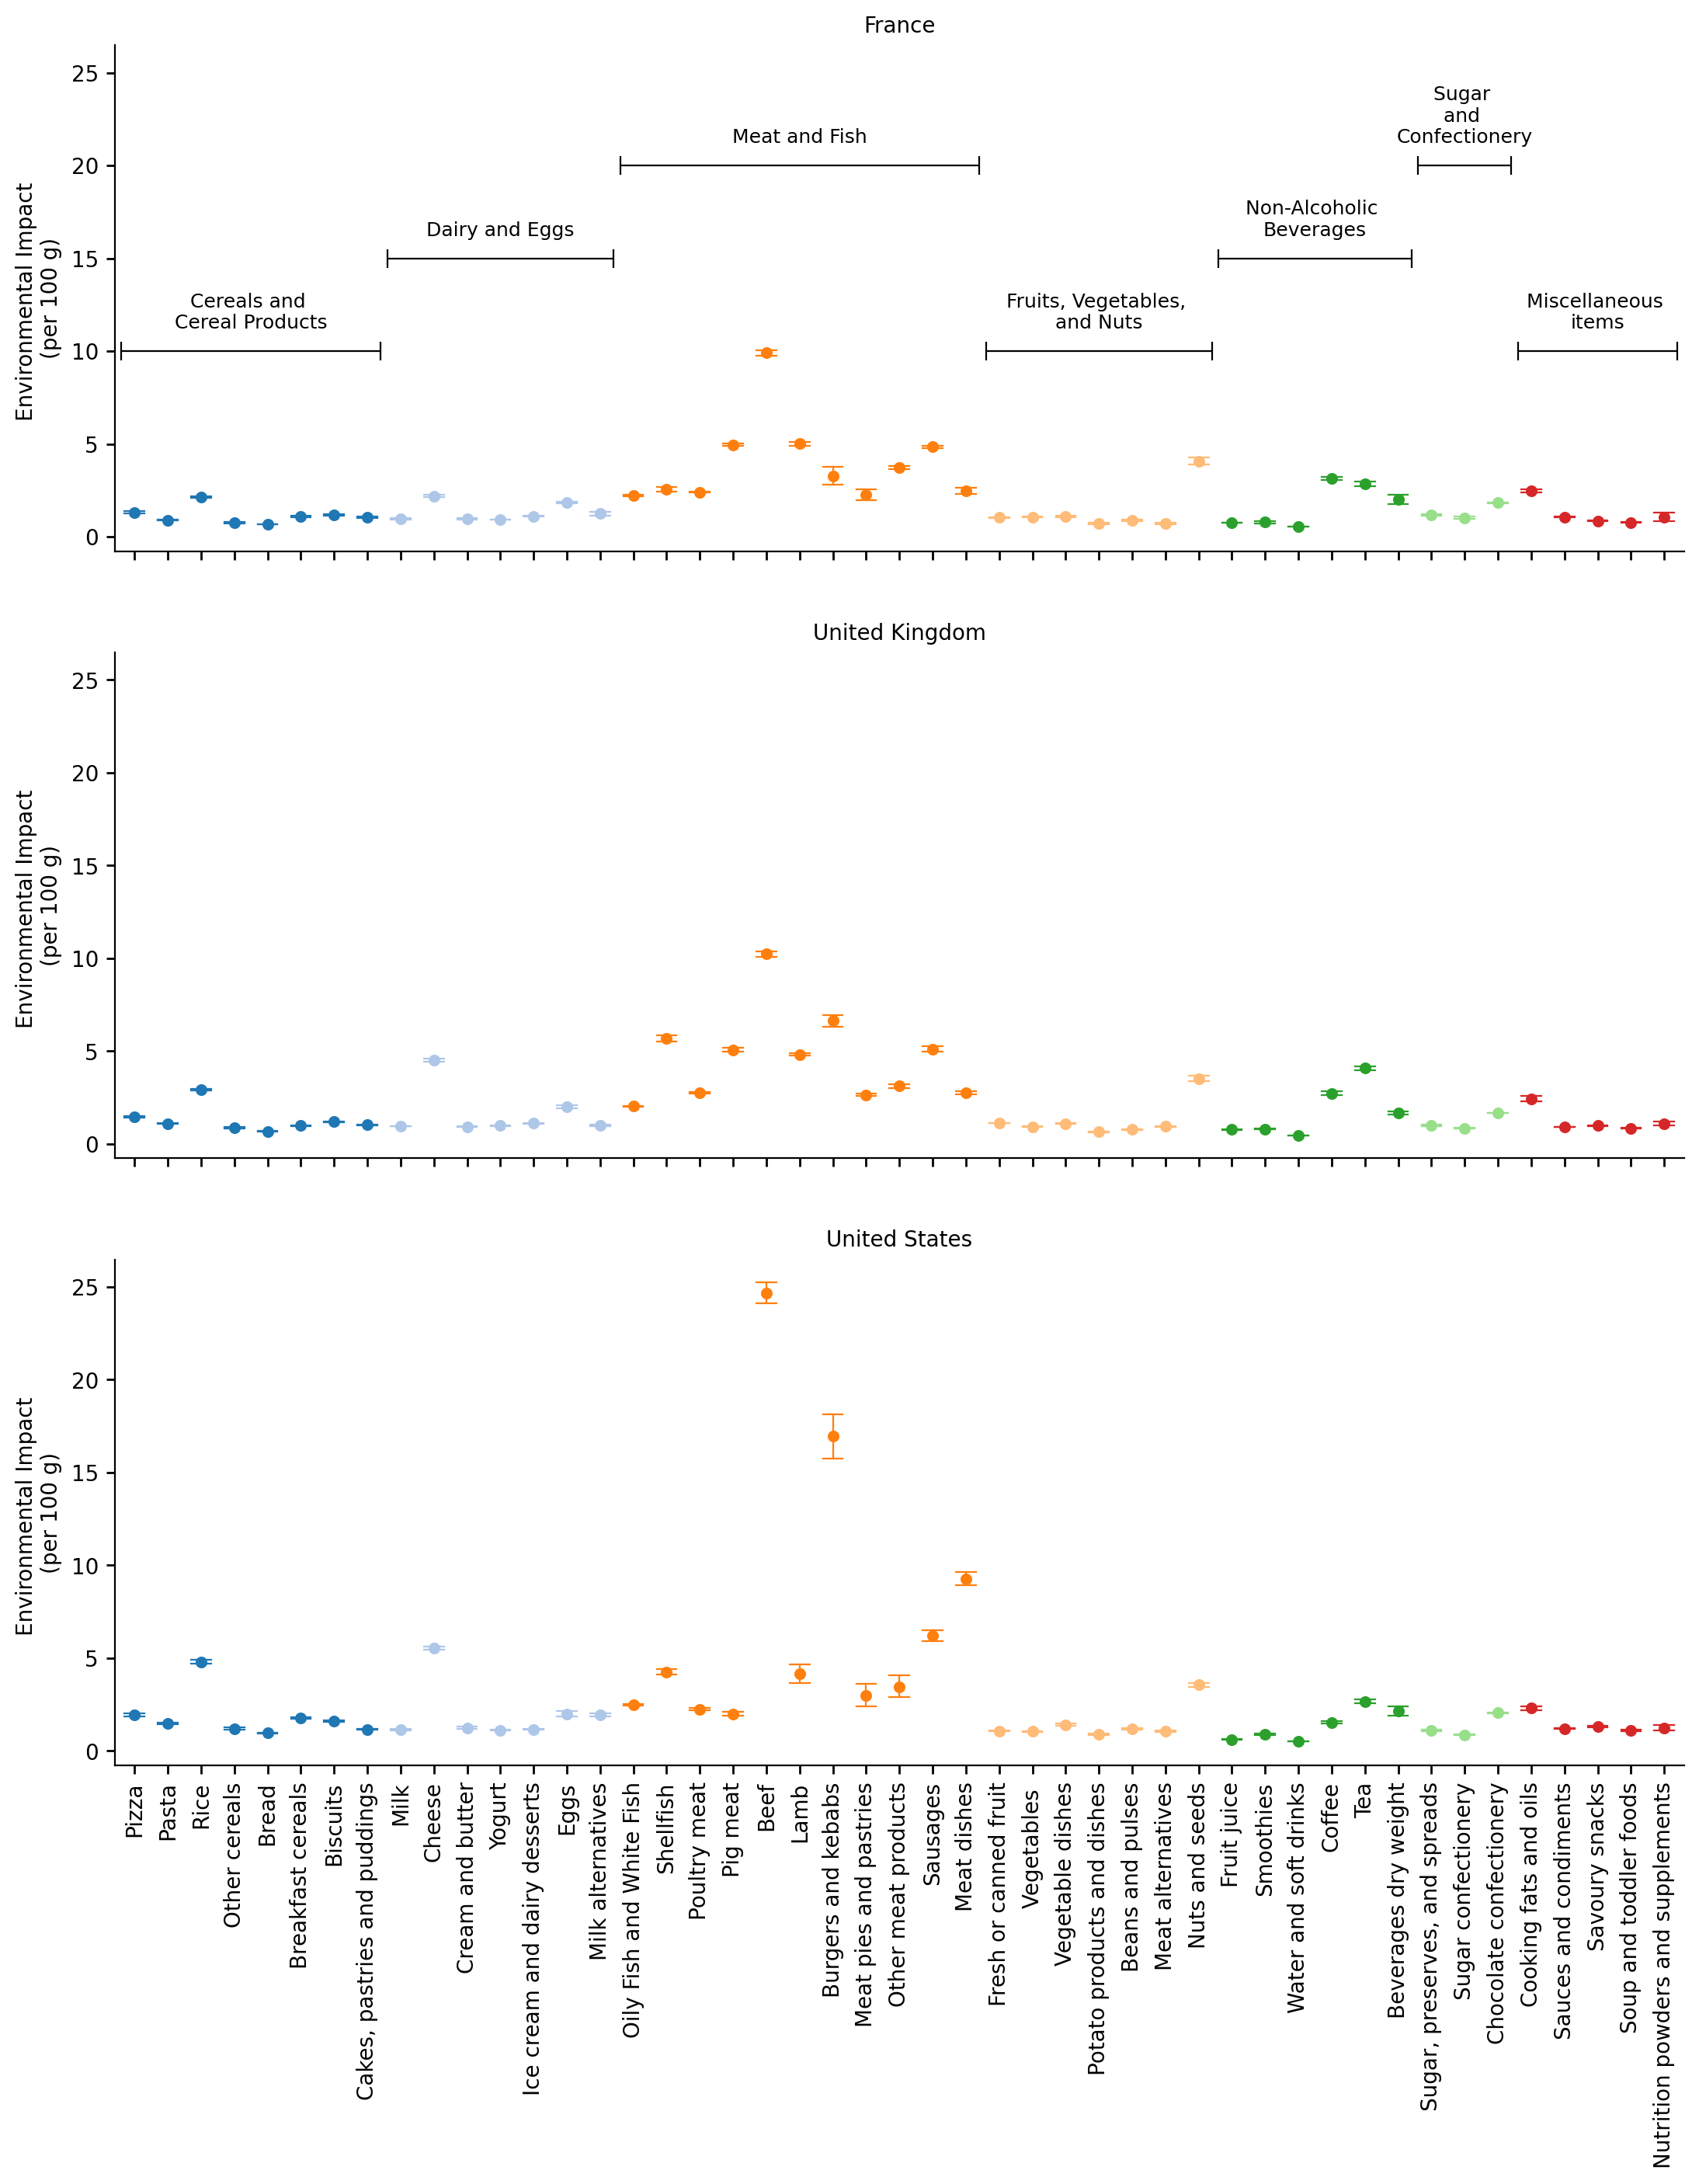

In [57]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  row='country', 
                  sharey=True,
                  height=4, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean_norm', 
        hue='groups',
        data=data.sort_values(by=['ID']), 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8,  
        markers='.',
        markersize=0.5,
        palette='tab20'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=1)
    ax.tick_params(axis='y', which='major', left=True, right=False, length=4, width=1)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}", size=10)
g.figure.subplots_adjust(hspace=0.2)

# Add group labels and lines with endpoint markers ONLY to the top plot (France)
top_ax = g.axes.flatten()[0]  

# Get x-tick positions and labels
xticks = g.axes.flatten()[2].get_xticks()
xticklabels = [label.get_text() for label in g.axes.flatten()[2].get_xticklabels()]

groups = [
    {"label": "Cereals and \nCereal Products", 
     "start": df_mapping[df_mapping['groups']=="Cereals and Cereal Products"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Cereals and Cereal Products"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 10},
    {"label": "Dairy and Eggs", 
     "start": df_mapping[df_mapping['groups']=="Dairy and Eggs"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Dairy and Eggs"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 15},
    {"label": "Meat and Fish", 
     "start": df_mapping[df_mapping['groups']=="Meat and Fish"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Meat and Fish"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 20},
    {"label": "Fruits, Vegetables, \nand Nuts", 
     "start": df_mapping[df_mapping['groups']=="Fruits, Vegetables, and Nuts"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Fruits, Vegetables, and Nuts"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 10},
    {"label": "Non-Alcoholic \nBeverages", 
     "start": df_mapping[df_mapping['groups']=="Non-Alcoholic Beverages"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Non-Alcoholic Beverages"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 15},
    {"label": "Sugar \nand \nConfectionery", 
     "start": df_mapping[df_mapping['groups']=="Sugar and Confectionery"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Sugar and Confectionery"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 20},
    {"label": "Miscellaneous \nitems", 
     "start": df_mapping[df_mapping['groups']=="Miscellaneous items"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Miscellaneous items"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 10}
]

# Add group annotations
for group in groups:
    try:
        xmin = xticks[xticklabels.index(group['start'])] - 0.4
        xmax = xticks[xticklabels.index(group['end'])] + 0.4

        # Add group label 
        top_ax.text((xmin + xmax) / 2, group['y'] + 1,
                    group['label'], ha='center', va='bottom',
                    fontsize=9)  

        # Add narrower horizontal line
        line_width = 0.8  # Narrower line width
        top_ax.hlines(y=group['y'], xmin=xmin, xmax=xmax, color='black', linewidth=line_width)

        # Add vertical bars at endpoints
        bar_height = 1  # Adjust height for subtle look
        top_ax.vlines(x=xmin, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
        top_ax.vlines(x=xmax, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
    except ValueError:
        # Skip if the label isn't found
        continue

# Remove extra space at the beginning of the x-axis
# Adjusting based on the actual tick positions
min_tick = min(xticks)
max_tick = max(xticks)
top_ax.set_xlim(min_tick - 0.6, max_tick + 0.6)  # Adding slight padding after trimming

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

#### diet differences

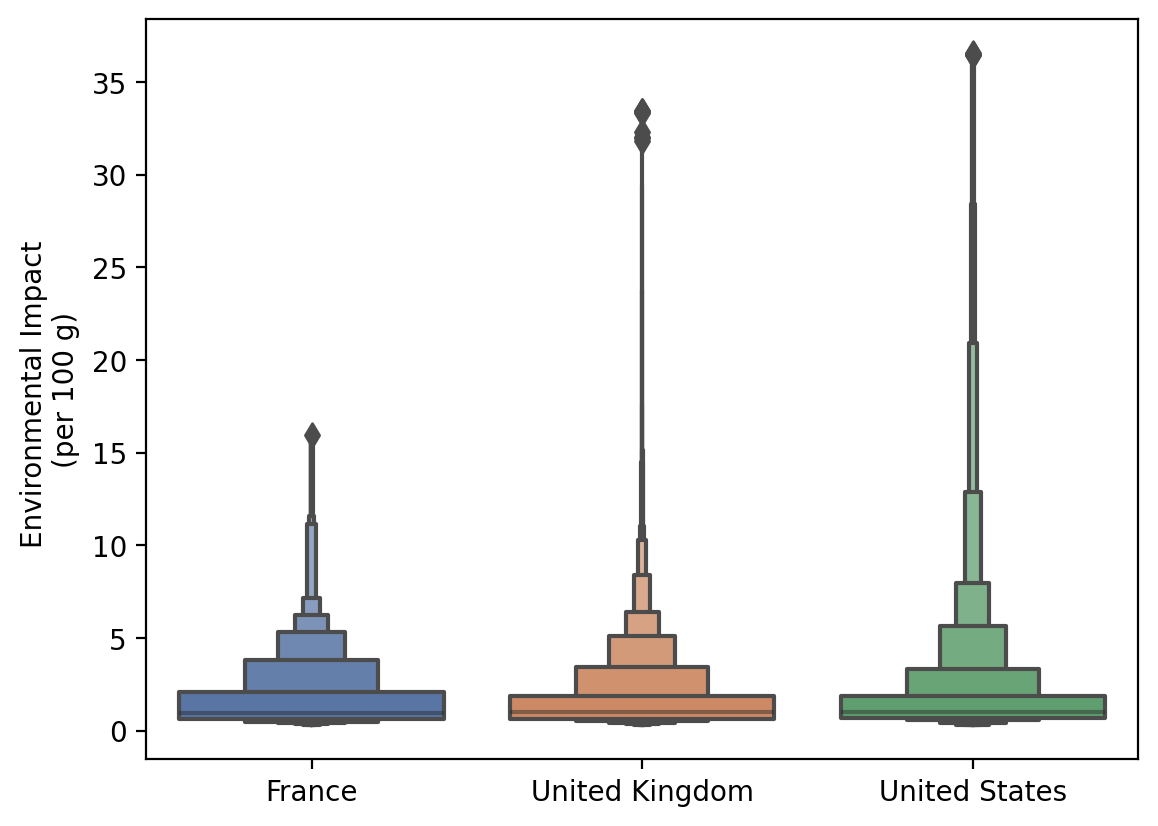

In [88]:
ax = sns.boxenplot(data=df_plot, y="mean_norm", x="country", palette='deep')
ax.set(ylabel='Environmental Impact \n(per 100 g)')
ax.set(xlabel='')
plt.show()

In [59]:
df_plot.groupby('country')[['mean_norm']].mean()

mean_norm
country                  
France           1.734768
United Kingdom   1.685444
United States    1.971243

In [60]:
df_mapping = df_plot[['groups', 'labels', 'ID']].drop_duplicates()
df_mapping['group_ID'] = df_mapping.apply(lambda row: row['ID'][:-1], axis=1)

parent_to_sub = {}
for parent in df_mapping['group_ID'].unique():
    subs = df_mapping[df_mapping['group_ID'] == parent]['ID'].tolist()
    subs_sorted = sorted(subs)
    parent_to_sub[parent] = subs_sorted
    
ordered_parents = sorted(parent_to_sub.keys())

# Create an overall ordered list of sub-categories, grouping by parent.
ordered_subs = []
for parent in ordered_parents:
    ordered_subs.extend(parent_to_sub[parent])

In [61]:
# Assign a base color to each parent (using a Seaborn palette)
base_colors = sns.color_palette("deep", len(ordered_parents))
parent_color_dict = {parent: base_colors[i] for i, parent in enumerate(ordered_parents)}

# For each parent, generate a palette for its sub-categories (variations on the parent's color)
sub_color_dict = {}
for parent in ordered_parents:
    n_sub = len(parent_to_sub[parent])
    # Get the parent's base color in hex format
    base_hex = matplotlib.colors.to_hex(parent_color_dict[parent])
    # Generate a light palette variant. reverse=True so the first sub-category gets the darkest shade.
    sub_palette = sns.light_palette(base_hex, n_colors=n_sub, reverse=True)
    for sub, color in zip(parent_to_sub[parent], sub_palette):
        sub_color_dict[sub] = color

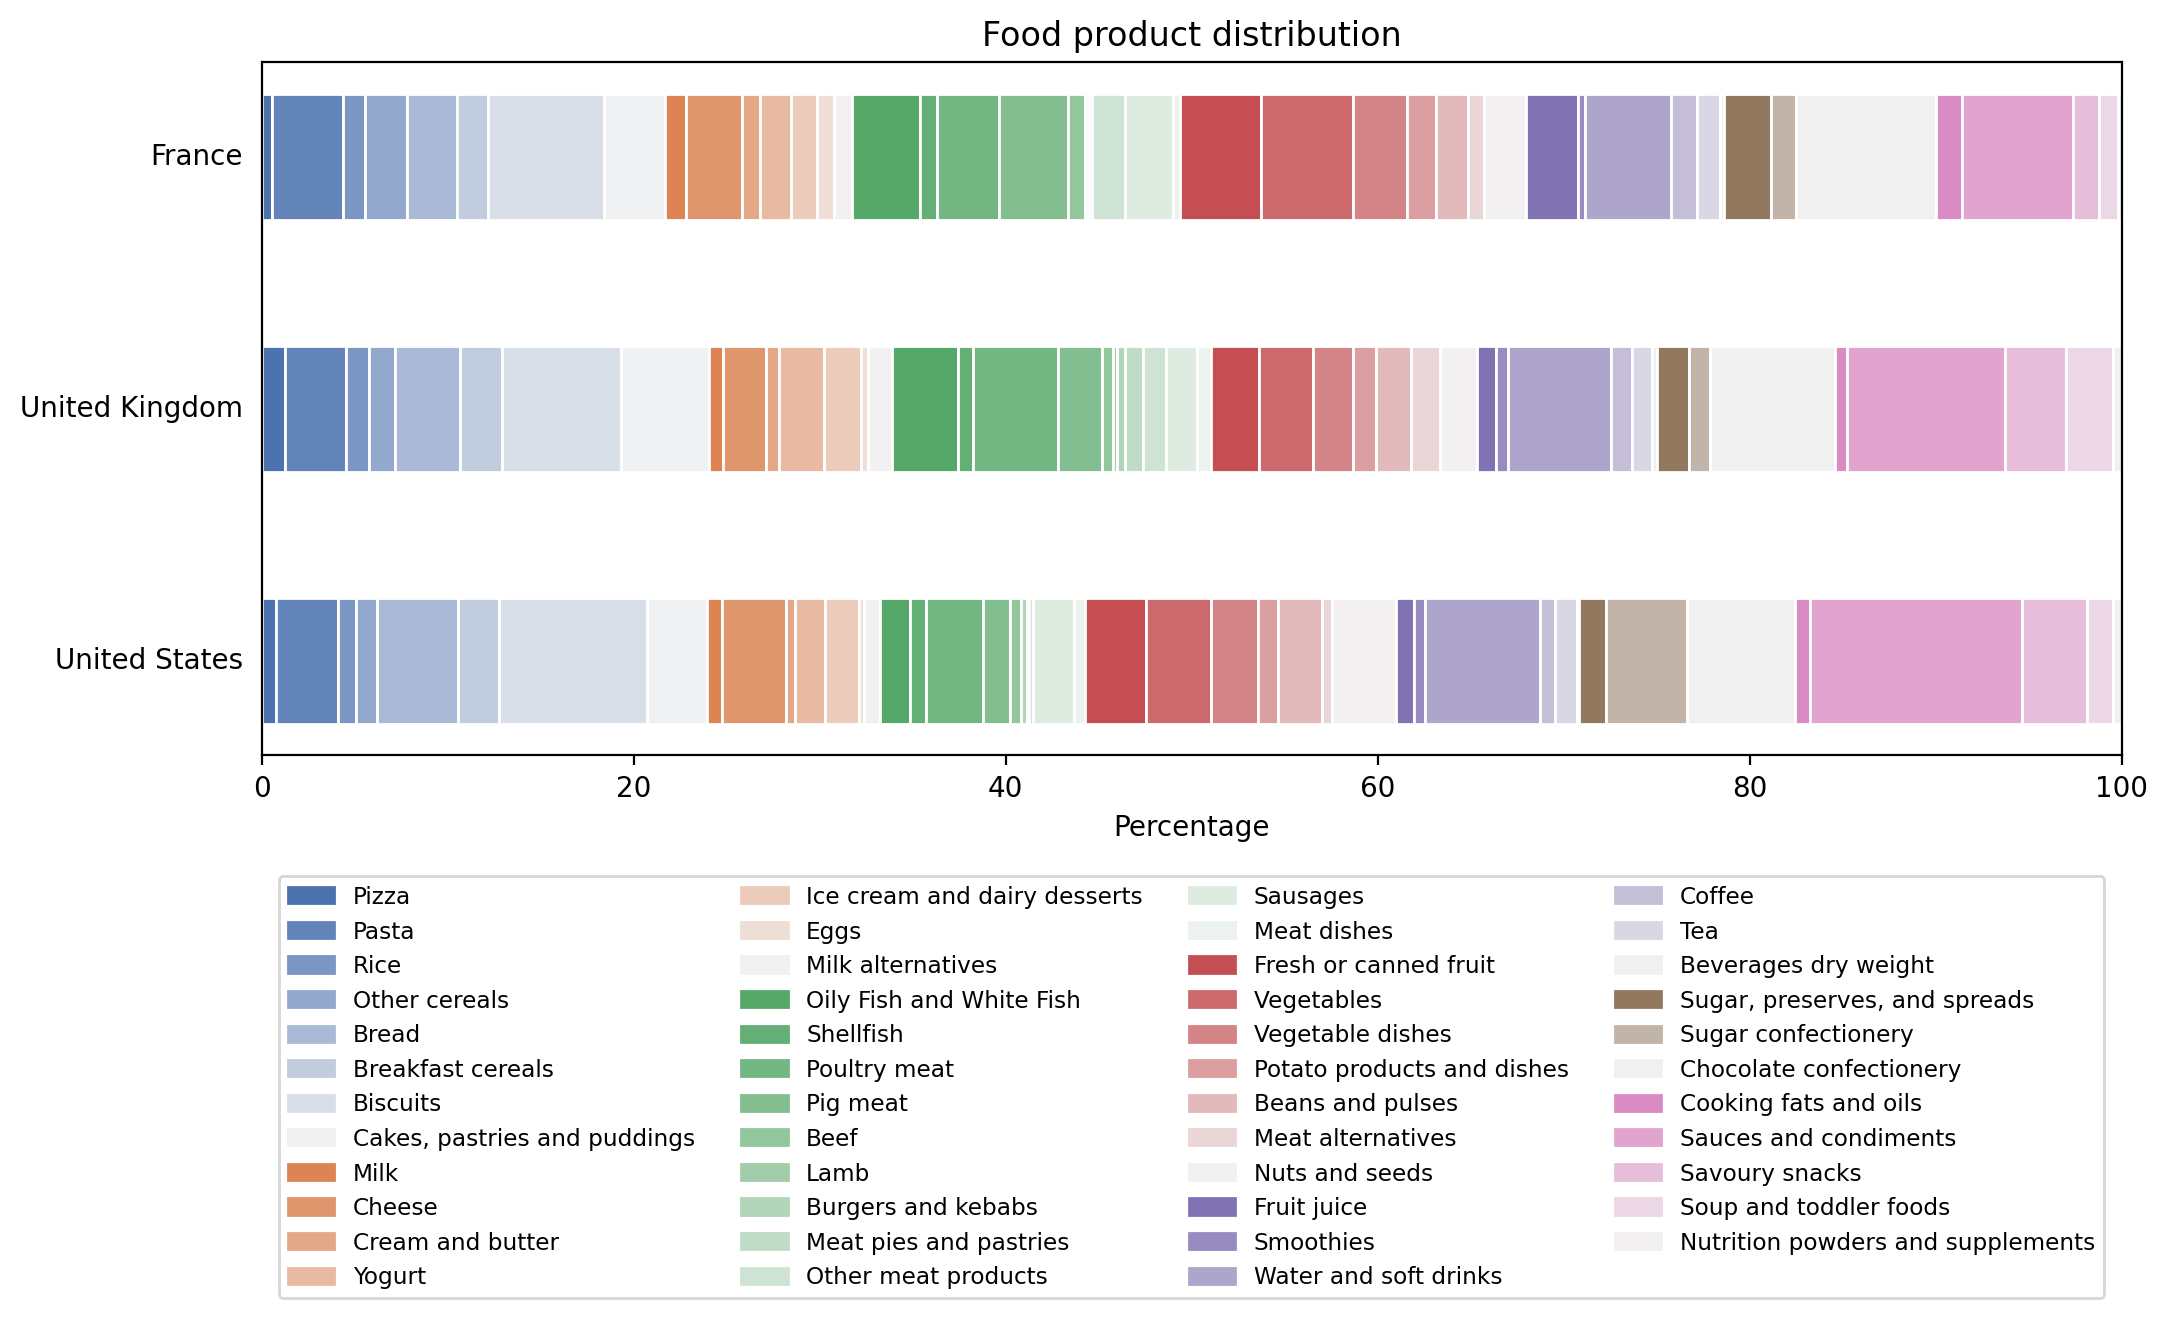

In [62]:
fig, ax = plt.subplots(figsize=(12, 4.5))

# Loop over countries. For each, compute percentages by sub_category and plot the stacked bar.
for i, country in enumerate(df_plot['country'].unique()[::-1]):
    df_country = df_plot[df_plot['country'] == country]
    counts = df_country['ID'].value_counts()
    total = counts.sum()
    left = 0  # starting position for stacking segments
    for sub in ordered_subs:
        count = counts.get(sub, 0)
        pct = (count / total * 100) if total > 0 else 0
        # Draw the horizontal bar segment for this sub_category.
        ax.barh(i, pct, left=left, color=sub_color_dict[sub], edgecolor='white', height=0.5)
        left += pct
    ax.text(-1, i, country, va='center', ha='right', fontsize=10)

ax.set_xlim(0, 100)
ax.set_yticks([])  # Hide default y-axis ticks since we annotated the country names.
ax.set_xlabel("Percentage")
ax.set_title("Food product distribution")

# Create legend for parent categories (using their base colors)
legend_handles = []
for sub, color in sub_color_dict.items():
    patch = mpatches.Patch(color=color, label=df_mapping[df_mapping['ID']==sub]['labels'].values[0])
    legend_handles.append(patch)

# ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(
    handles=legend_handles,
    loc='lower center',                
    bbox_to_anchor=(0.5, -0.8), 
    ncol=4,
    fontsize='small',
    # frameon=False
)

# plt.tight_layout()
plt.show()


#### ingredient/composition differences

In [63]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Impact_Proportions_By_Product_*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

props = pd.concat(df_list, axis=0, ignore_index=True)

In [64]:
props[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut', 
       #'tmp.impact_Acidification','tmp.impact_WaterUse',
      'tmp.impact_WatScar', 'tmp.impact_Biodiversity']] = props[[
    'tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut', 
    #'tmp.impact_Acidification', 'tmp.impact_WaterUse',
    'tmp.impact_WatScar', 'tmp.impact_Biodiversity']].fillna(0)

In [65]:
props = props.merge(impacts[['product_id', 'country', 'mean_Land', 'mean_GHG', 'mean_Eut',
                             'mean_WatScar', 'mean_Biodiversity',
                             'mean_Acidification', 'mean_WaterUse']], left_on='id', right_on='product_id')

In [66]:
props['tmp.impact_Land'] = (props['tmp.impact_Land']/props['amount']) * props['mean_Land']
props['tmp.impact_GHG'] = (props['tmp.impact_GHG']/props['amount']) * props['mean_GHG']
props['tmp.impact_Eut'] = (props['tmp.impact_Eut']/props['amount']) * props['mean_Eut']
props['tmp.impact_WatScar'] = (props['tmp.impact_WatScar']/props['amount']) * props['mean_WatScar'] 
props['tmp.impactBiodiversity'] = (props['tmp.impact_Biodiversity']/props['amount']) * props['mean_Biodiversity'] 
# props['tmp.impact_Acidification'] = (props['tmp.impact_Acidification']/props['amount']) * props['mean_Acidification'] 
# props['tmp.impact_WaterUse'] = (props['tmp.impact_WaterUse']/props['amount']) * props['mean_WaterUse'] 

In [67]:
impact_groups = props.groupby('Food_Category')[[
    'tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
    #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
    'tmp.impact_WatScar', 'tmp.impact_Biodiversity'
]].mean().reset_index()

In [68]:
for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
            #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
            'tmp.impact_WatScar', 'tmp.impact_Biodiversity']:
    impact_groups[col] = 100 * (impact_groups[col] - impact_groups[col].min()) / (impact_groups[col].max() - impact_groups[col].min())

In [69]:
impact_groups['impact'] = impact_groups[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
                         #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
                         'tmp.impact_WatScar', 'tmp.impact_Biodiversity']].mean(axis=1) 

In [70]:
impact_groups['impact_groups'] = pd.qcut(impact_groups.impact, 5, labels=[1, 2, 3, 4, 5])

In [71]:
impact_groups.sort_values(by='impact')[['Food_Category', 'impact', 'impact_groups']]

Food_Category     impact impact_groups
45                      Salt   0.611329             1
53                     Water   0.611329             1
31            Onions & Leeks   1.272457             1
12                   Cassava   1.666773             1
4              Barley (Beer)   1.728244             1
44           Root Vegetables   1.908357             1
23              Maize (Meal)   2.682304             1
39                  Potatoes   2.687490             1
52                  Tomatoes   2.979347             1
5                 Beet Sugar   3.556814             1
15              Citrus Fruit   4.170973             1
55                      Wine   4.355137             1
51                      Tofu   4.604221             2
13  Cereals & Oilcrops Misc.   5.350404             2
2                     Apples   5.390451             2
41              Rapeseed Oil   5.396473             2
10      Butter, Cream & Ghee   5.455232             2
28                   Oatmeal   5.574816             2
9                  Brassicas   5.834726             2
33              Other Pulses   5.996154             2
37                      Peas   6.104280             2
24                      Milk   6.665502             2
54       Wheat & Rye (Bread)   6.905764             2
11                Cane Sugar   7.451400             3
6           Berries & Grapes   7.642283             3
21                Groundnuts   7.712525             3
49           Sunflower seeds   7.796803             3
32               Other Fruit   8.056807             3
19                      Eggs   8.301227             3
46               Soybean Oil   8.624557             3
34          Other Vegetables   8.650974             3
36                  Palm Oil  10.276321             3
48             Sunflower Oil  11.301417             3
25            Milk Chocolate  11.801545             3
3                    Bananas  13.341530             4
30                    Olives  15.119004             4
42                      Rice  16.264633             4
47                   Soymilk  17.092818             4
1                Animal Fats  18.285712             4
29                 Olive Oil  20.891993             4
27                  Oat milk  21.015176             4
20                      Fish  21.669671             4
16                    Coffee  21.936156             4
43                 Rice milk  22.153546             4
18            Dark Chocolate  23.232774             4
35            Other nut milk  23.882701             5
40              Poultry Meat  24.561849             5
38                  Pig Meat  27.439516             5
17               Crustaceans  29.671953             5
26                      Nuts  30.432118             5
14                    Cheese  30.449256             5
0                Almond milk  30.596649             5
50                       Tea  30.910831             5
22             Lamb & Mutton  32.616948             5
7    Bovine Meat (beef herd)  58.154787             5
8   Bovine Meat (dairy herd)  74.435275             5

In [77]:
composition_sub = composition.merge(df_plot[['product_id', 'groups', 'labels', 'ID', 'mean_norm']], 
                                    left_on='id', right_on='product_id')

composition_sub = composition_sub.groupby(['country', 'groups', 'labels', 
                                           'ID', 'Food_Category'])[['percent']].sum().reset_index()

def get_perc(g):
    g['percent'] = (g['percent'] / g['percent'].sum()) * 100
    return g

composition_sub = composition_sub.groupby(['country', 'ID']).apply(lambda g: get_perc(g)).reset_index(drop=True)

composition_sub.loc[composition_sub['Food_Category']=='Fish (farmed)', 'Food_Category'] = 'Fish'
composition_sub.loc[composition_sub['Food_Category']=='Crustaceans (farmed)', 'Food_Category'] = 'Crustaceans'
composition_sub = composition_sub.merge(impact_groups[['Food_Category', 'impact_groups']], how='left')
composition_sub.loc[composition_sub['impact_groups'].isna(), 'impact_groups'] = 1

composition_sub = composition_sub.groupby(['country', 'ID', 'impact_groups'])[['percent']].sum().reset_index()
composition_sub = composition_sub.merge(df_mapping)

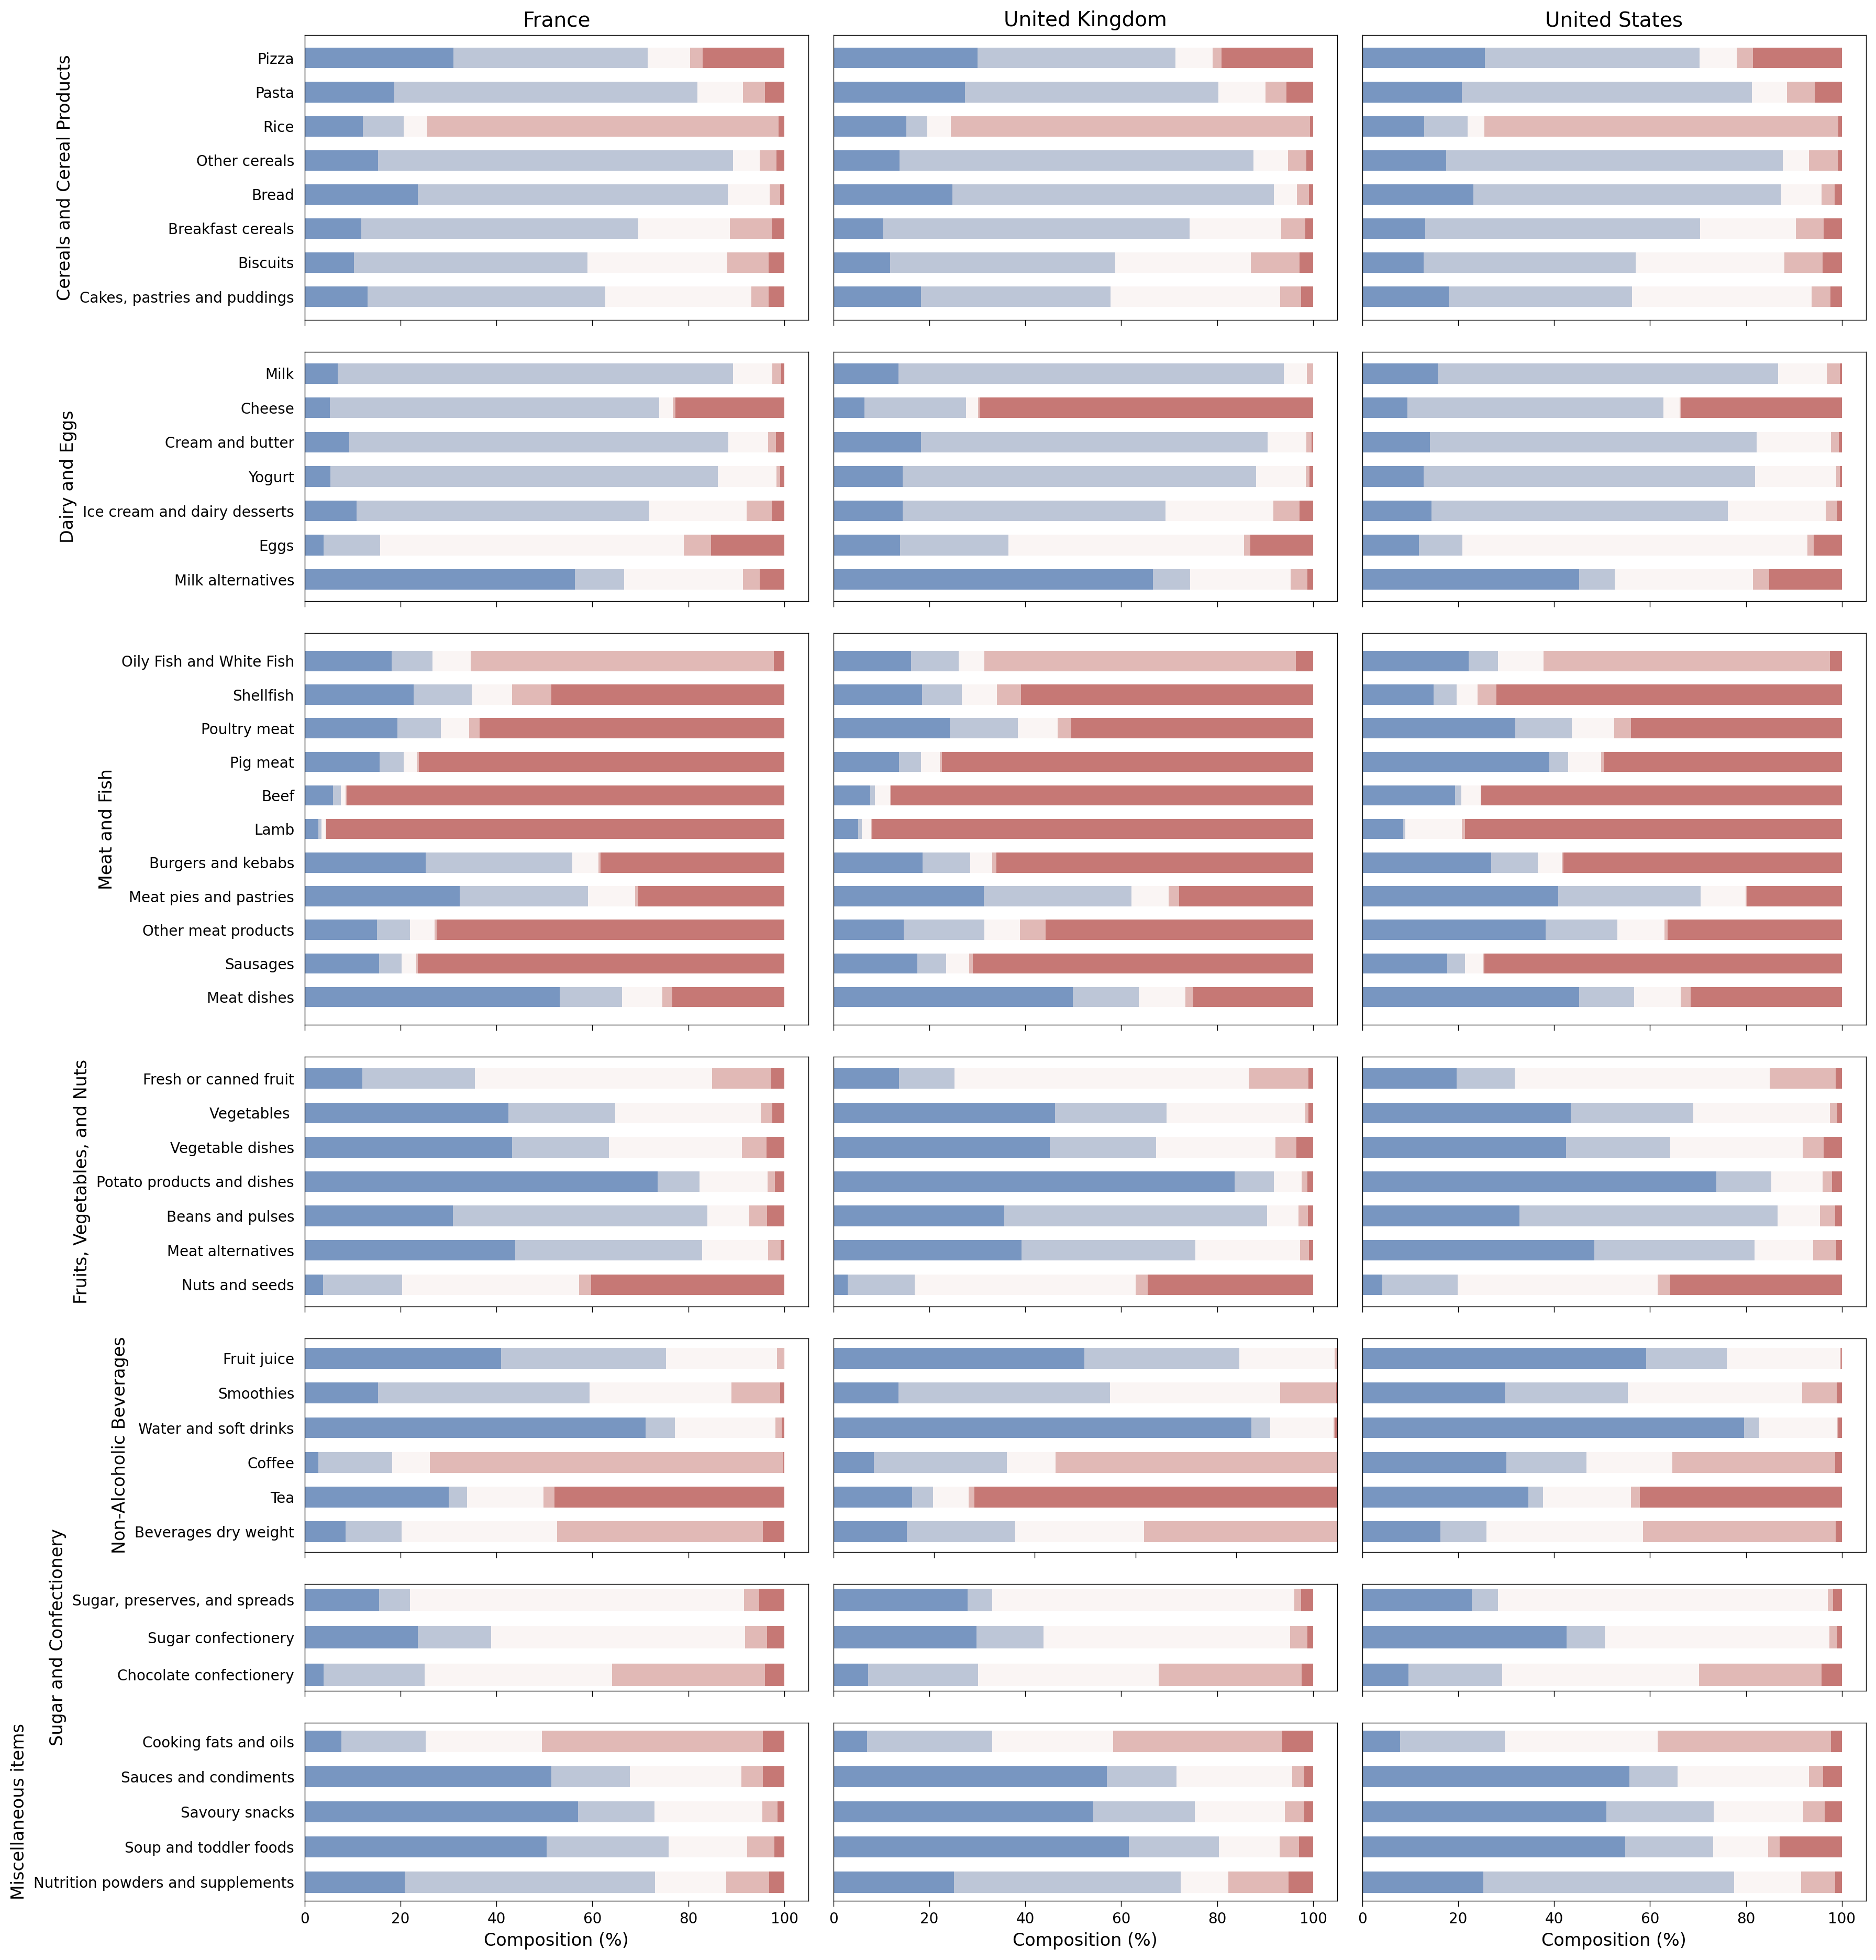

In [86]:
groups_list = ['Cereals and Cereal Products', 'Dairy and Eggs', 'Meat and Fish',
               'Fruits, Vegetables, and Nuts', 'Non-Alcoholic Beverages',
               'Sugar and Confectionery', 'Miscellaneous items']
countries_list = ['France', 'United Kingdom', 'United States']


facet_counts = {}
for group in groups_list:
    for country in countries_list:
        data_sub = composition_sub[(composition_sub['groups'] == group) & (composition_sub['country'] == country)]
        count = data_sub['labels'].nunique() if not data_sub.empty else 0
        facet_counts[(group, country)] = count
        
inch_per_label = 0.4  
row_heights = []
for group in groups_list:
    max_count = max(facet_counts[(group, country)] for country in countries_list)
    row_heights.append(max_count * inch_per_label)

fig_width = len(countries_list) * 6  
fig_height = sum(row_heights)

fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(nrows=len(groups_list), ncols=len(countries_list),
                       height_ratios=row_heights)

def plot_stacked_barh(ax, data):
    pivot = data.pivot(index=['ID', "labels"], columns="impact_groups", values="percent").reset_index()
    pivot = pivot.fillna(0)
    pivot = pivot.sort_values('ID', ascending=False)

    labels = pivot['labels'].tolist()
    n = len(labels)
    positions = np.arange(n)

    bar_height = 0.6
    pivot = pivot.drop('ID', axis=1).set_index('labels')
    impact_groups = sorted(pivot.columns)

    # Define a color palette (consistent across facets)
    palette = sns.color_palette("vlag", n_colors=len(impact_groups))
    color_map = dict(zip(impact_groups, palette))

    # Plot each segment of the stacked bar.
    left = np.zeros(n)  # starting offset for each bar
    for group in impact_groups:
        ax.barh(y=positions,
                width=pivot[group].values,
                left=left,
                height=bar_height,
                label=group,
                color=color_map[group])
        left += pivot[group].values  # update the offset

    # Set y-ticks and labels
    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    
    # Remove gridlines and spines for a cleaner look
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        
legend_handles = None

for i, group in enumerate(groups_list):
    for j, country in enumerate(countries_list):
        ax = fig.add_subplot(gs[i, j])
        
        # Filter data for this facet.
        data_sub = composition_sub[(composition_sub['groups'] == group) & (composition_sub['country'] == country)]
        if not data_sub.empty:
            plot_stacked_barh(ax, data_sub)
        else:
            ax.set_visible(False)
        
        ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=0.5)
        ax.tick_params(axis='y', which='major', left=False, right=False)
        if i == 0:
            ax.set_title(country, fontsize=14)
        if i!=len(groups_list)-1:
            ax.set_xticklabels("") 
        if i==len(groups_list)-1:
            ax.set_xlabel("Composition (%)", fontsize=12)
        if j == 0:
            ax.set_ylabel(group, fontsize=12)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels("")
            
        if legend_handles is None and not data_sub.empty:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles = (handles, labels)

# if legend_handles is not None:
#     handles, leg_labels = legend_handles
#     # Place the legend below all subplots.
#     fig.legend(handles, leg_labels, title="Impact Groups", loc="lower center",
#                ncol=len(handles), bbox_to_anchor=(0.5, 0.01))

# Adjust layout
plt.tight_layout(h_pad=1.8, w_pad=1.4, 
                 # rect=[0, 0.05, 1, 1]
                )
plt.show()

In [89]:
composition_sub = composition.merge(df_plot[['product_id', 'groups', 'labels', 'ID', 'mean_norm']], 
                                    left_on='id', right_on='product_id')

composition_sub = composition_sub.groupby(['country', 'Food_Category'])[['percent']].sum().reset_index()

def get_perc(g):
    g['percent'] = (g['percent'] / g['percent'].sum()) * 100
    return g

composition_sub = composition_sub.groupby(['country']).apply(lambda g: get_perc(g)).reset_index(drop=True)

composition_sub.loc[composition_sub['Food_Category']=='Fish (farmed)', 'Food_Category'] = 'Fish'
composition_sub.loc[composition_sub['Food_Category']=='Crustaceans (farmed)', 'Food_Category'] = 'Crustaceans'
composition_sub = composition_sub.merge(impact_groups[['Food_Category', 'impact_groups']], how='left')
composition_sub.loc[composition_sub['impact_groups'].isna(), 'impact_groups'] = 1

composition_sub = composition_sub.groupby(['country', 'impact_groups'])[['percent']].sum().reset_index()

In [90]:
composition_sub

country impact_groups    percent
0           France             1  23.954839
1           France             2  29.230595
2           France             3  21.882634
3           France             4  10.525045
4           France             5  14.406886
5   United Kingdom             1  29.810577
6   United Kingdom             2  27.667000
7   United Kingdom             3  19.984592
8   United Kingdom             4   9.152474
9   United Kingdom             5  13.385357
10   United States             1  31.779041
11   United States             2  26.880599
12   United States             3  23.703878
13   United States             4   6.928221
14   United States             5  10.708261

#### importance of sourcing - also what does impacts figure look like without incorporating sourcing?

In [91]:
sourcing_diff = props

In [92]:
sourcing_diff['id'].nunique()

322249

In [93]:
sourcing_diff.shape

(1778289, 25)

In [94]:
for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
            #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
            'tmp.impact_WatScar', 'tmp.impact_Biodiversity']:
    sourcing_diff[col] = 100 * (sourcing_diff[col] - sourcing_diff[col].min()) / (sourcing_diff[col].max() - sourcing_diff[col].min())
    
sourcing_diff['impact'] = sourcing_diff[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
                                         #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
                                         'tmp.impact_WatScar', 'tmp.impact_Biodiversity' 
                                         ]].mean(axis=1) 

sourcing_diff_plot = sourcing_diff[sourcing_diff['country'].isin(['France', 'United Kingdom', 'United States'])]

sourcing_diff_plot = sourcing_diff_plot.merge(impact_groups[['Food_Category', 'impact_groups']])

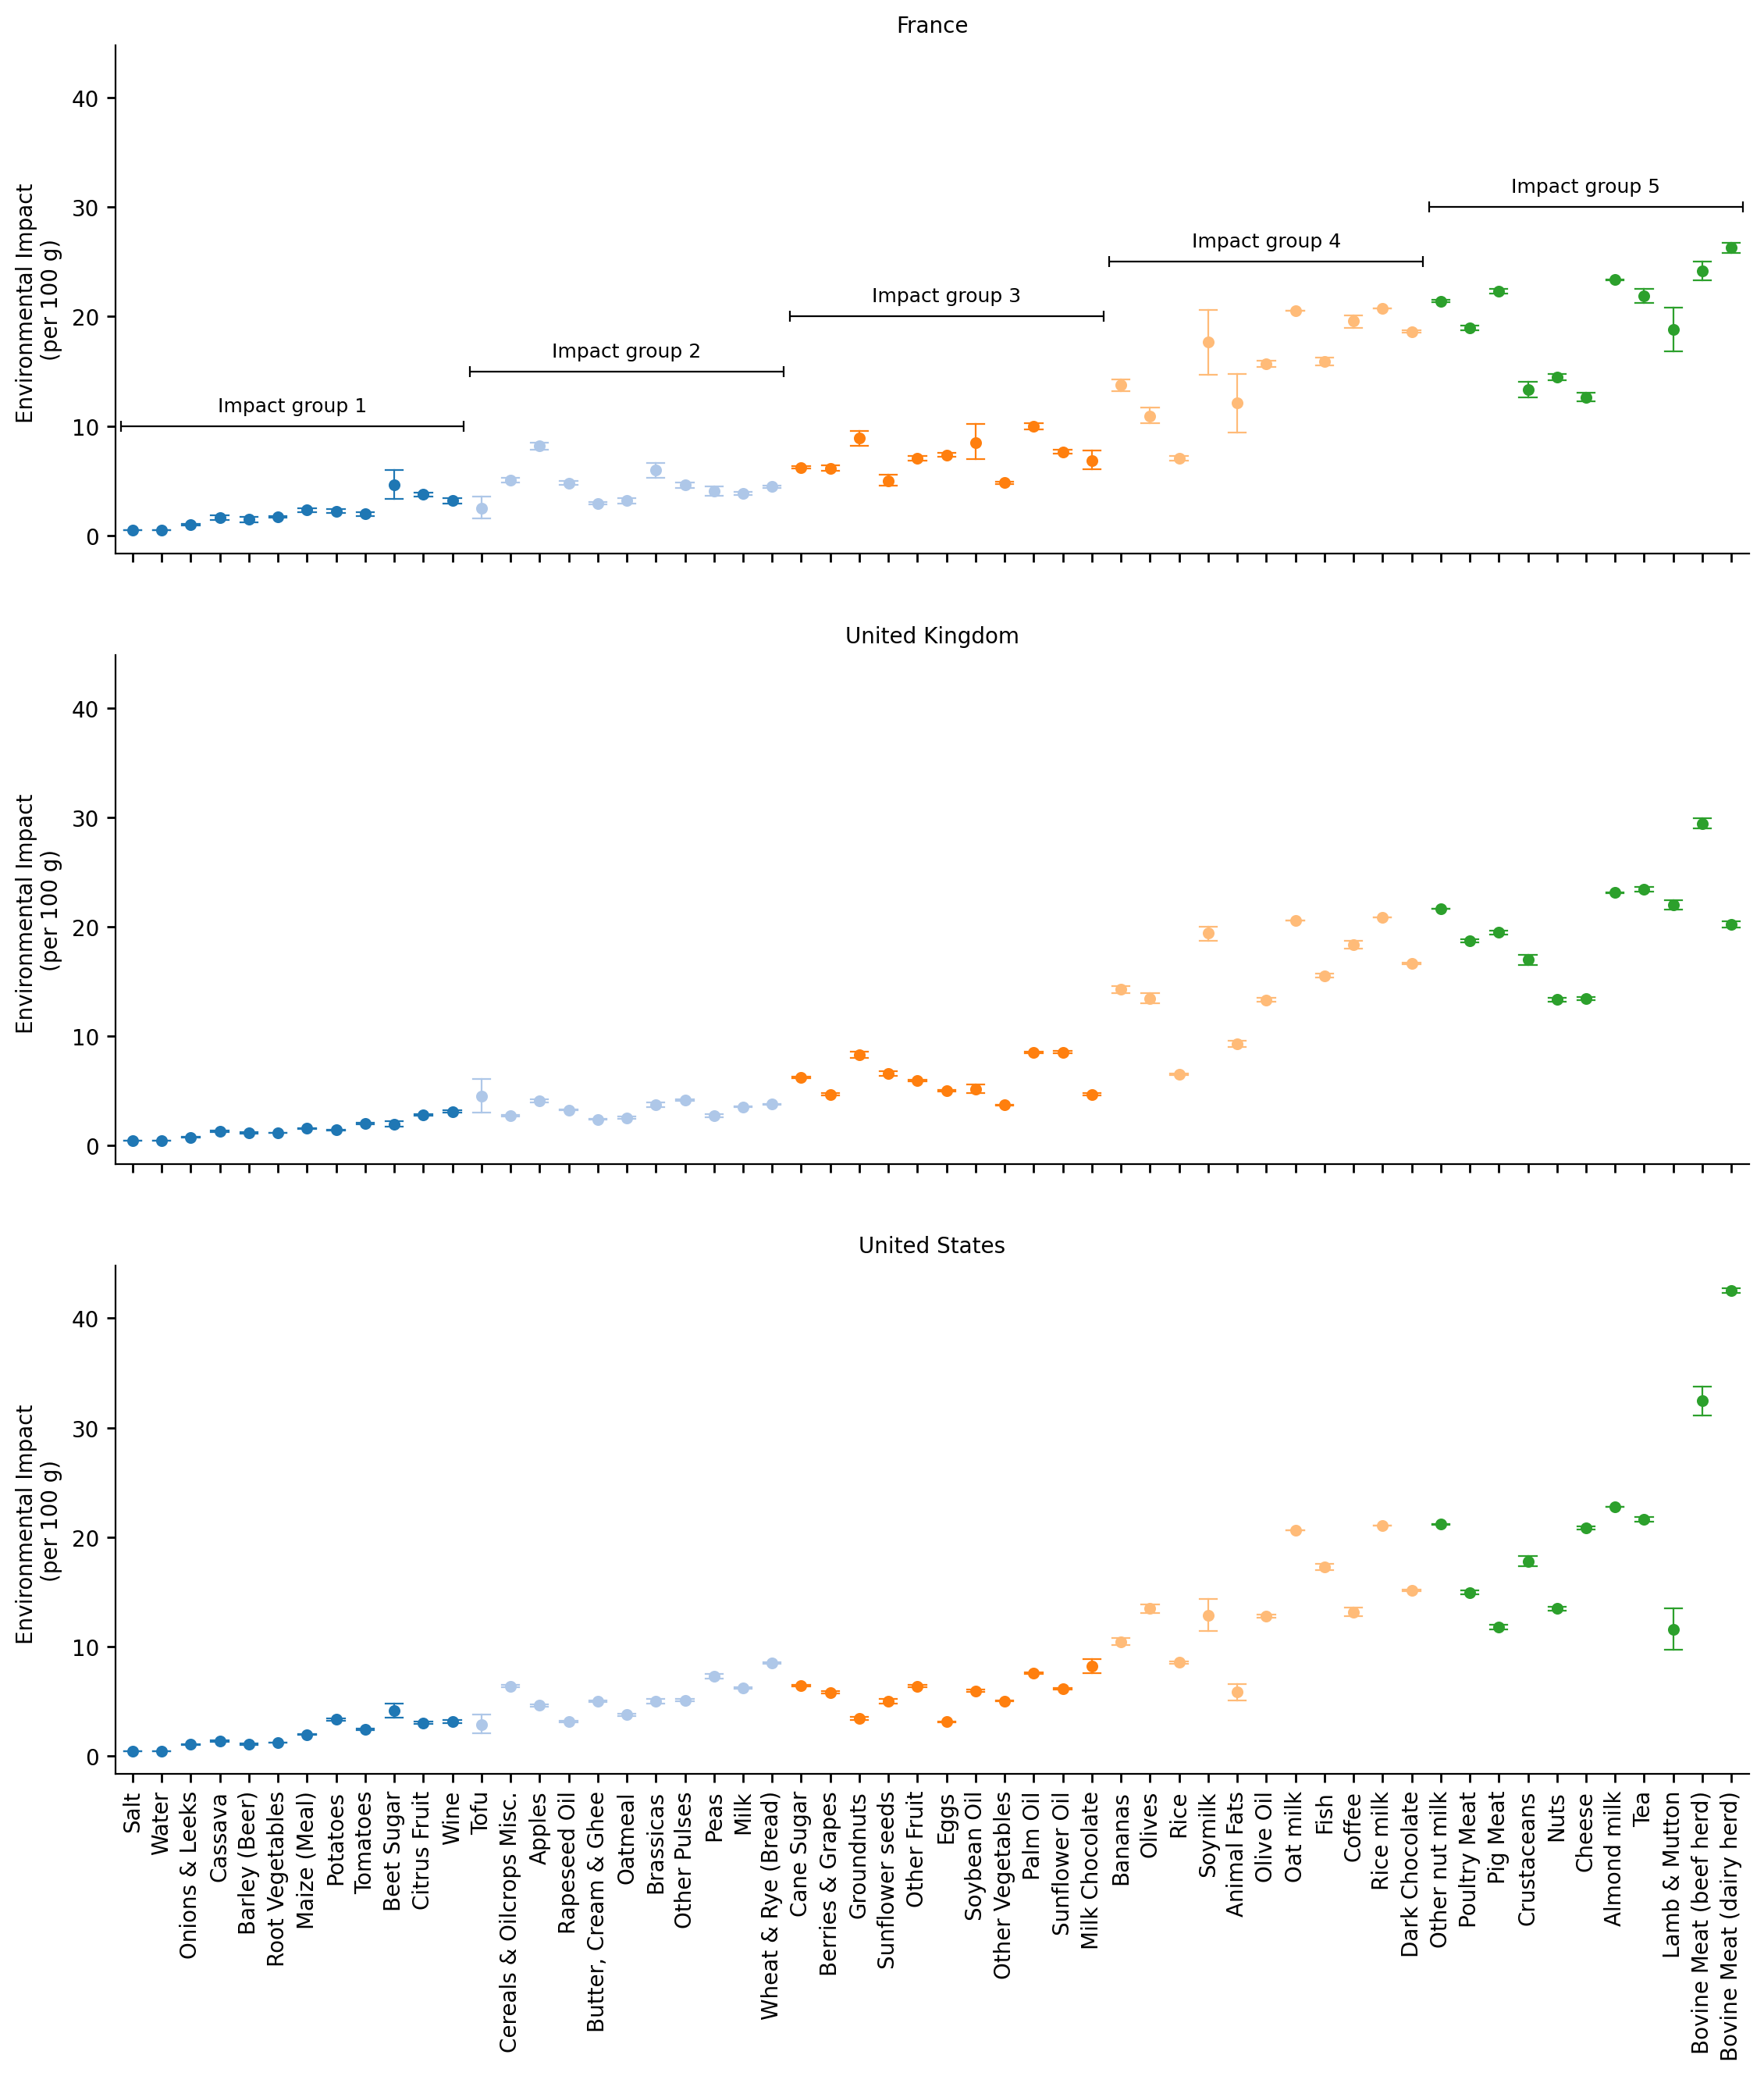

In [95]:
# Initialize the FacetGrid
g = sns.FacetGrid(sourcing_diff_plot, 
                  row='country', 
                  row_order=['France', 'United Kingdom', 'United States'],
                  sharey=True,
                  height=4, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='Food_Category', 
        y='impact', 
        hue='impact_groups',
        order=impact_groups.sort_values(by='impact').reset_index(drop=True)['Food_Category'].values.tolist(),
        data=data, 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8,  
        markers='.',
        markersize=0.5,
        palette='tab20'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=1)
    ax.tick_params(axis='y', which='major', left=True, right=False, length=4, width=1)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}", size=10)
g.figure.subplots_adjust(hspace=0.2)

# Add group labels and lines with endpoint markers ONLY to the top plot 
top_ax = g.axes.flatten()[0]  

# Get x-tick positions and labels
xticks = g.axes.flatten()[2].get_xticks()
xticklabels = [label.get_text() for label in g.axes.flatten()[2].get_xticklabels()]



groups = [
    {"label": "Impact group 1",
     "start": impact_groups[impact_groups['impact_groups']==1].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==1].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 10},
    {"label": "Impact group 2", 
     "start": impact_groups[impact_groups['impact_groups']==2].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==2].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 15},
    {"label": "Impact group 3", 
     "start": impact_groups[impact_groups['impact_groups']==3].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==3].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 20},
    {"label": "Impact group 4", 
     "start": impact_groups[impact_groups['impact_groups']==4].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==4].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 25},
    {"label": "Impact group 5", 
     "start": impact_groups[impact_groups['impact_groups']==5].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==5].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 30}
]

# Add group annotations
for group in groups:
    try:
        xmin = xticks[xticklabels.index(group['start'])] - 0.4
        xmax = xticks[xticklabels.index(group['end'])] + 0.4

        # Add group label
        top_ax.text((xmin + xmax) / 2, group['y'] + 1,
                    group['label'], ha='center', va='bottom',
                    fontsize=9)  # No bold, slightly smaller font size

        # Add narrower horizontal line
        line_width = 0.8  
        top_ax.hlines(y=group['y'], xmin=xmin, xmax=xmax, color='black', linewidth=line_width)

        # Add vertical bars at endpoints
        bar_height = 1  # Adjust height for subtle look
        top_ax.vlines(x=xmin, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
        top_ax.vlines(x=xmax, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
    except ValueError:
        # Skip if the label isn't found
        continue

# Remove extra space at the beginning of the x-axis
# Adjusting based on the actual tick positions
min_tick = min(xticks)
max_tick = max(xticks)
top_ax.set_xlim(min_tick - 0.6, max_tick + 0.6)  # Adding slight padding after trimming

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

In [96]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Total_Impacts_By_Product_global*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

impacts_global = pd.concat(df_list, axis=0, ignore_index=True)

impacts_global = products_cats.merge(impacts_global.drop('product_name', axis=1), left_on='product_id', 
                              right_on='id').drop('id', axis=1)

impacts_global = impacts_global.merge(impacts[['product_id', 'labels', 'groups', 'ID']])

In [147]:
impacts_global.shape

(333514, 133)

In [98]:
score_columns = ['Land', 
                 'GHG', 
                 'Eut', 
                 'WatScar',
                 'Biodiversity', 
                 # 'Acidification', 
                 # 'WaterUse'
                ]

# Melt the aggregated dataframe to long format for seaborn
melted_df_global = impacts_global.melt(
    id_vars=['country', 'groups', 'labels', 'ID', 'product_id'],
    value_vars=[f"mean_{score}" for score in score_columns],
    var_name='score',
    value_name='mean'
)

# Extract the score name
melted_df_global['score'] = melted_df_global['score'].str.replace('_mean', '')
melted_df_global['score'] = melted_df_global['score'].str.replace('mean_', '')

melted_df_global = melted_df_global.groupby('score').apply(lambda g: get_norm(g)).reset_index(drop=True)

melted_df_global = melted_df_global.groupby(['country', 'groups', 'labels', 'ID', 'product_id'])[['mean_norm']].mean().reset_index()

df_plot_global = melted_df_global[melted_df_global['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot_global = df_plot_global[df_plot_global['labels']!='mis']

In [99]:
df_plot_global.shape

(314303, 6)

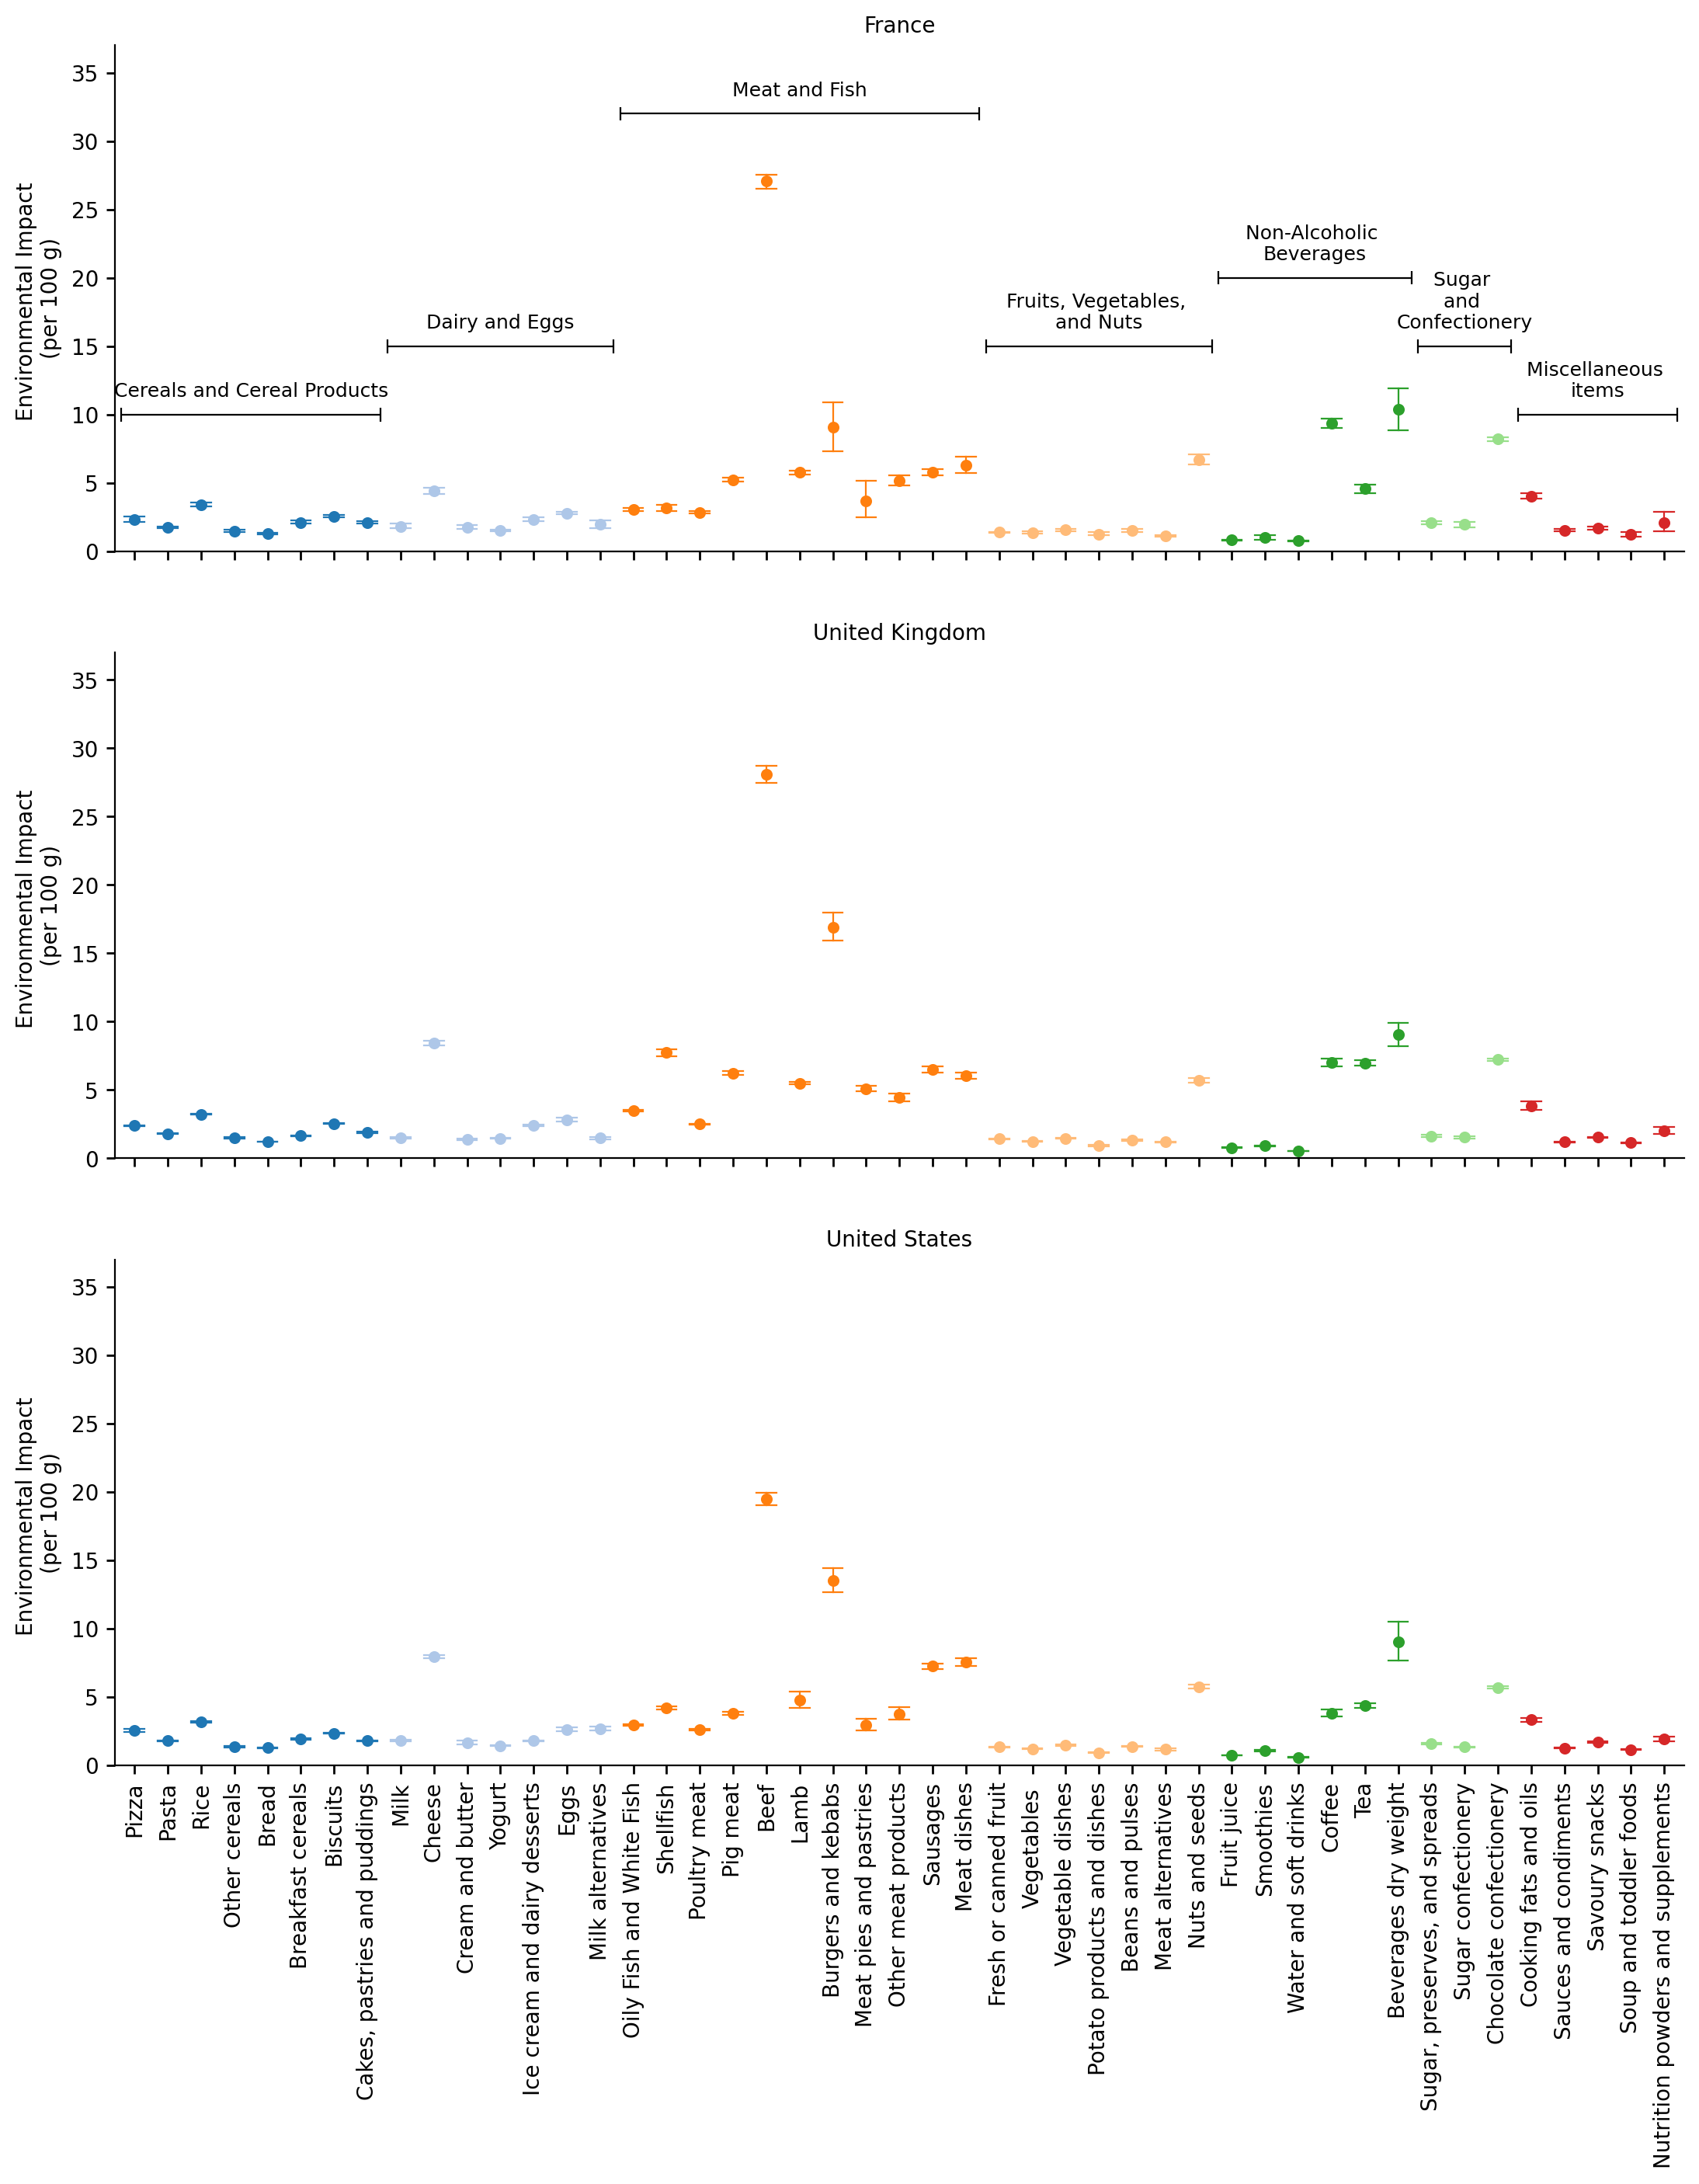

In [100]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot_global, 
                  row='country', 
                  sharey=True,
                  height=4, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean_norm', 
        hue='groups',
        data=data.sort_values(by=['ID']), 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8, 
        markers='.',
        markersize=0.5,
        palette='tab20'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=1)
    ax.tick_params(axis='y', which='major', left=True, right=False, length=4, width=1)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}", size=10)
g.figure.subplots_adjust(hspace=0.2)

# Add group labels and lines with endpoint markers ONLY to the top plot
top_ax = g.axes.flatten()[0]  

# Get x-tick positions and labels
xticks = g.axes.flatten()[2].get_xticks()
xticklabels = [label.get_text() for label in g.axes.flatten()[2].get_xticklabels()]

groups = [
    {"label": "Cereals and Cereal Products", 
     "start": df_mapping[df_mapping['groups']=="Cereals and Cereal Products"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Cereals and Cereal Products"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 10},
    {"label": "Dairy and Eggs", 
     "start": df_mapping[df_mapping['groups']=="Dairy and Eggs"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Dairy and Eggs"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 15},
    {"label": "Meat and Fish", 
     "start": df_mapping[df_mapping['groups']=="Meat and Fish"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Meat and Fish"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 32},
    {"label": "Fruits, Vegetables, \nand Nuts", 
     "start": df_mapping[df_mapping['groups']=="Fruits, Vegetables, and Nuts"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Fruits, Vegetables, and Nuts"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 15},
    {"label": "Non-Alcoholic \nBeverages", 
     "start": df_mapping[df_mapping['groups']=="Non-Alcoholic Beverages"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Non-Alcoholic Beverages"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 20},
    {"label": "Sugar \nand \nConfectionery", 
     "start": df_mapping[df_mapping['groups']=="Sugar and Confectionery"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Sugar and Confectionery"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 15},
    {"label": "Miscellaneous \nitems", 
     "start": df_mapping[df_mapping['groups']=="Miscellaneous items"].sort_values(by=['ID'])['labels'].values[0], 
     "end": df_mapping[df_mapping['groups']=="Miscellaneous items"].sort_values(by=['ID'])['labels'].values[-1], 
     "y": 10}
]


# Add group annotations
for group in groups:
    try:
        xmin = xticks[xticklabels.index(group['start'])] - 0.4
        xmax = xticks[xticklabels.index(group['end'])] + 0.4

        # Add group label 
        top_ax.text((xmin + xmax) / 2, group['y'] + 1,
                    group['label'], ha='center', va='bottom',
                    fontsize=9)  

        # Add narrower horizontal line
        line_width = 0.8  # Narrower line width
        top_ax.hlines(y=group['y'], xmin=xmin, xmax=xmax, color='black', linewidth=line_width)

        # Add vertical bars at endpoints
        bar_height = 1  # Adjust height for subtle look
        top_ax.vlines(x=xmin, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
        top_ax.vlines(x=xmax, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
    except ValueError:
        # Skip if the label isn't found
        continue

# Remove extra space at the beginning of the x-axis
# Adjusting based on the actual tick positions
min_tick = min(xticks)
max_tick = max(xticks)
top_ax.set_xlim(min_tick - 0.6, max_tick + 0.6)  # Adding slight padding after trimming
top_ax.set_ylim(0, 37)

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

In [169]:
melted_df_compare = melted_df.merge(melted_df_global, on=['country', 'groups', 'labels', 'ID', 'product_id'])

In [170]:
melted_df_compare['mean_norm_x'].corr(melted_df_compare['mean_norm_y'])

0.7772026722653841

In [171]:
melted_df_compare.groupby('country')[['mean_norm_x','mean_norm_y']].corr().unstack().iloc[:,1]

country
Australia         0.922090
Canada            0.745468
France            0.778635
Ireland           0.827794
New Zealand       0.833351
United Kingdom    0.823975
United States     0.862964
Name: (mean_norm_x, mean_norm_y), dtype: float64

In [172]:
melted_df_compare = melted_df_compare[(melted_df_compare['labels']!='mis')
                 # & (melted_df_compare['country'].isin(['France', 'United Kingdom', 'United States']))
                 ].groupby(['country', 'groups', 'labels', 'ID'])[['mean_norm_x','mean_norm_y']].corr().unstack().reset_index()
melted_df_compare.columns = ['country', 'groups', 'labels', 'ID', 'drop1', 'corr', 'drop2', 'drop3']
melted_df_compare = melted_df_compare.drop(['drop1', 'drop2', 'drop3'], axis=1)
melted_df_compare = melted_df_compare.pivot(index=['groups', 'labels', 'ID'], columns='country', values='corr').reset_index()
melted_df_compare.sort_values(by='ID')

country                        groups                             labels  ID  \
6         Cereals and Cereal Products                              Pizza  1A   
5         Cereals and Cereal Products                              Pasta  1B   
7         Cereals and Cereal Products                               Rice  1C   
4         Cereals and Cereal Products                      Other cereals  1D   
1         Cereals and Cereal Products                              Bread  1E   
2         Cereals and Cereal Products                  Breakfast cereals  1F   
0         Cereals and Cereal Products                           Biscuits  1G   
3         Cereals and Cereal Products       Cakes, pastries and puddings  1H   
12                     Dairy and Eggs                               Milk  2A   
8                      Dairy and Eggs                             Cheese  2B   
9                      Dairy and Eggs                   Cream and butter  2C   
14                     Dairy and Eggs                             Yogurt  2D   
11                     Dairy and Eggs       Ice cream and dairy desserts  2E   
10                     Dairy and Eggs                               Eggs  2F   
13                     Dairy and Eggs                  Milk alternatives  2G   
27                      Meat and Fish           Oily Fish and White Fish  3A   
32                      Meat and Fish                          Shellfish  3B   
30                      Meat and Fish                       Poultry meat  3C   
29                      Meat and Fish                           Pig meat  3D   
22                      Meat and Fish                               Beef  3E   
24                      Meat and Fish                               Lamb  3F   
23                      Meat and Fish                 Burgers and kebabs  3G   
26                      Meat and Fish             Meat pies and pastries  3H   
28                      Meat and Fish                Other meat products  3I   
31                      Meat and Fish                           Sausages  3J   
25                      Meat and Fish                        Meat dishes  3K   
16       Fruits, Vegetables, and Nuts              Fresh or canned fruit  4A   
21       Fruits, Vegetables, and Nuts                        Vegetables   4B   
20       Fruits, Vegetables, and Nuts                   Vegetable dishes  4C   
19       Fruits, Vegetables, and Nuts         Potato products and dishes  4D   
15       Fruits, Vegetables, and Nuts                   Beans and pulses  4E   
17       Fruits, Vegetables, and Nuts                  Meat alternatives  4F   
18       Fruits, Vegetables, and Nuts                     Nuts and seeds  4G   
40            Non-Alcoholic Beverages                        Fruit juice  5A   
41            Non-Alcoholic Beverages                          Smoothies  5B   
43            Non-Alcoholic Beverages              Water and soft drinks  5C   
39            Non-Alcoholic Beverages                             Coffee  5D   
42            Non-Alcoholic Beverages                                Tea  5E   
38            Non-Alcoholic Beverages               Beverages dry weight  5F   
46            Sugar and Confectionery      Sugar, preserves, and spreads  6A   
45            Sugar and Confectionery                Sugar confectionery  6B   
44            Sugar and Confectionery            Chocolate confectionery  6C   
33                Miscellaneous items              Cooking fats and oils  7A   
35                Miscellaneous items              Sauces and condiments  7B   
36                Miscellaneous items                     Savoury snacks  7C   
37                Miscellaneous items             Soup and toddler foods  7D   
34                Miscellaneous items  Nutrition powders and supplements  7E   

country  Australia    Canada    France   Ireland  New Zealand  United Kingdom  \
6         0.996813  0.950456  0.791112  0.946163     0.999288        0.934443 

#### summary of all other countries

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


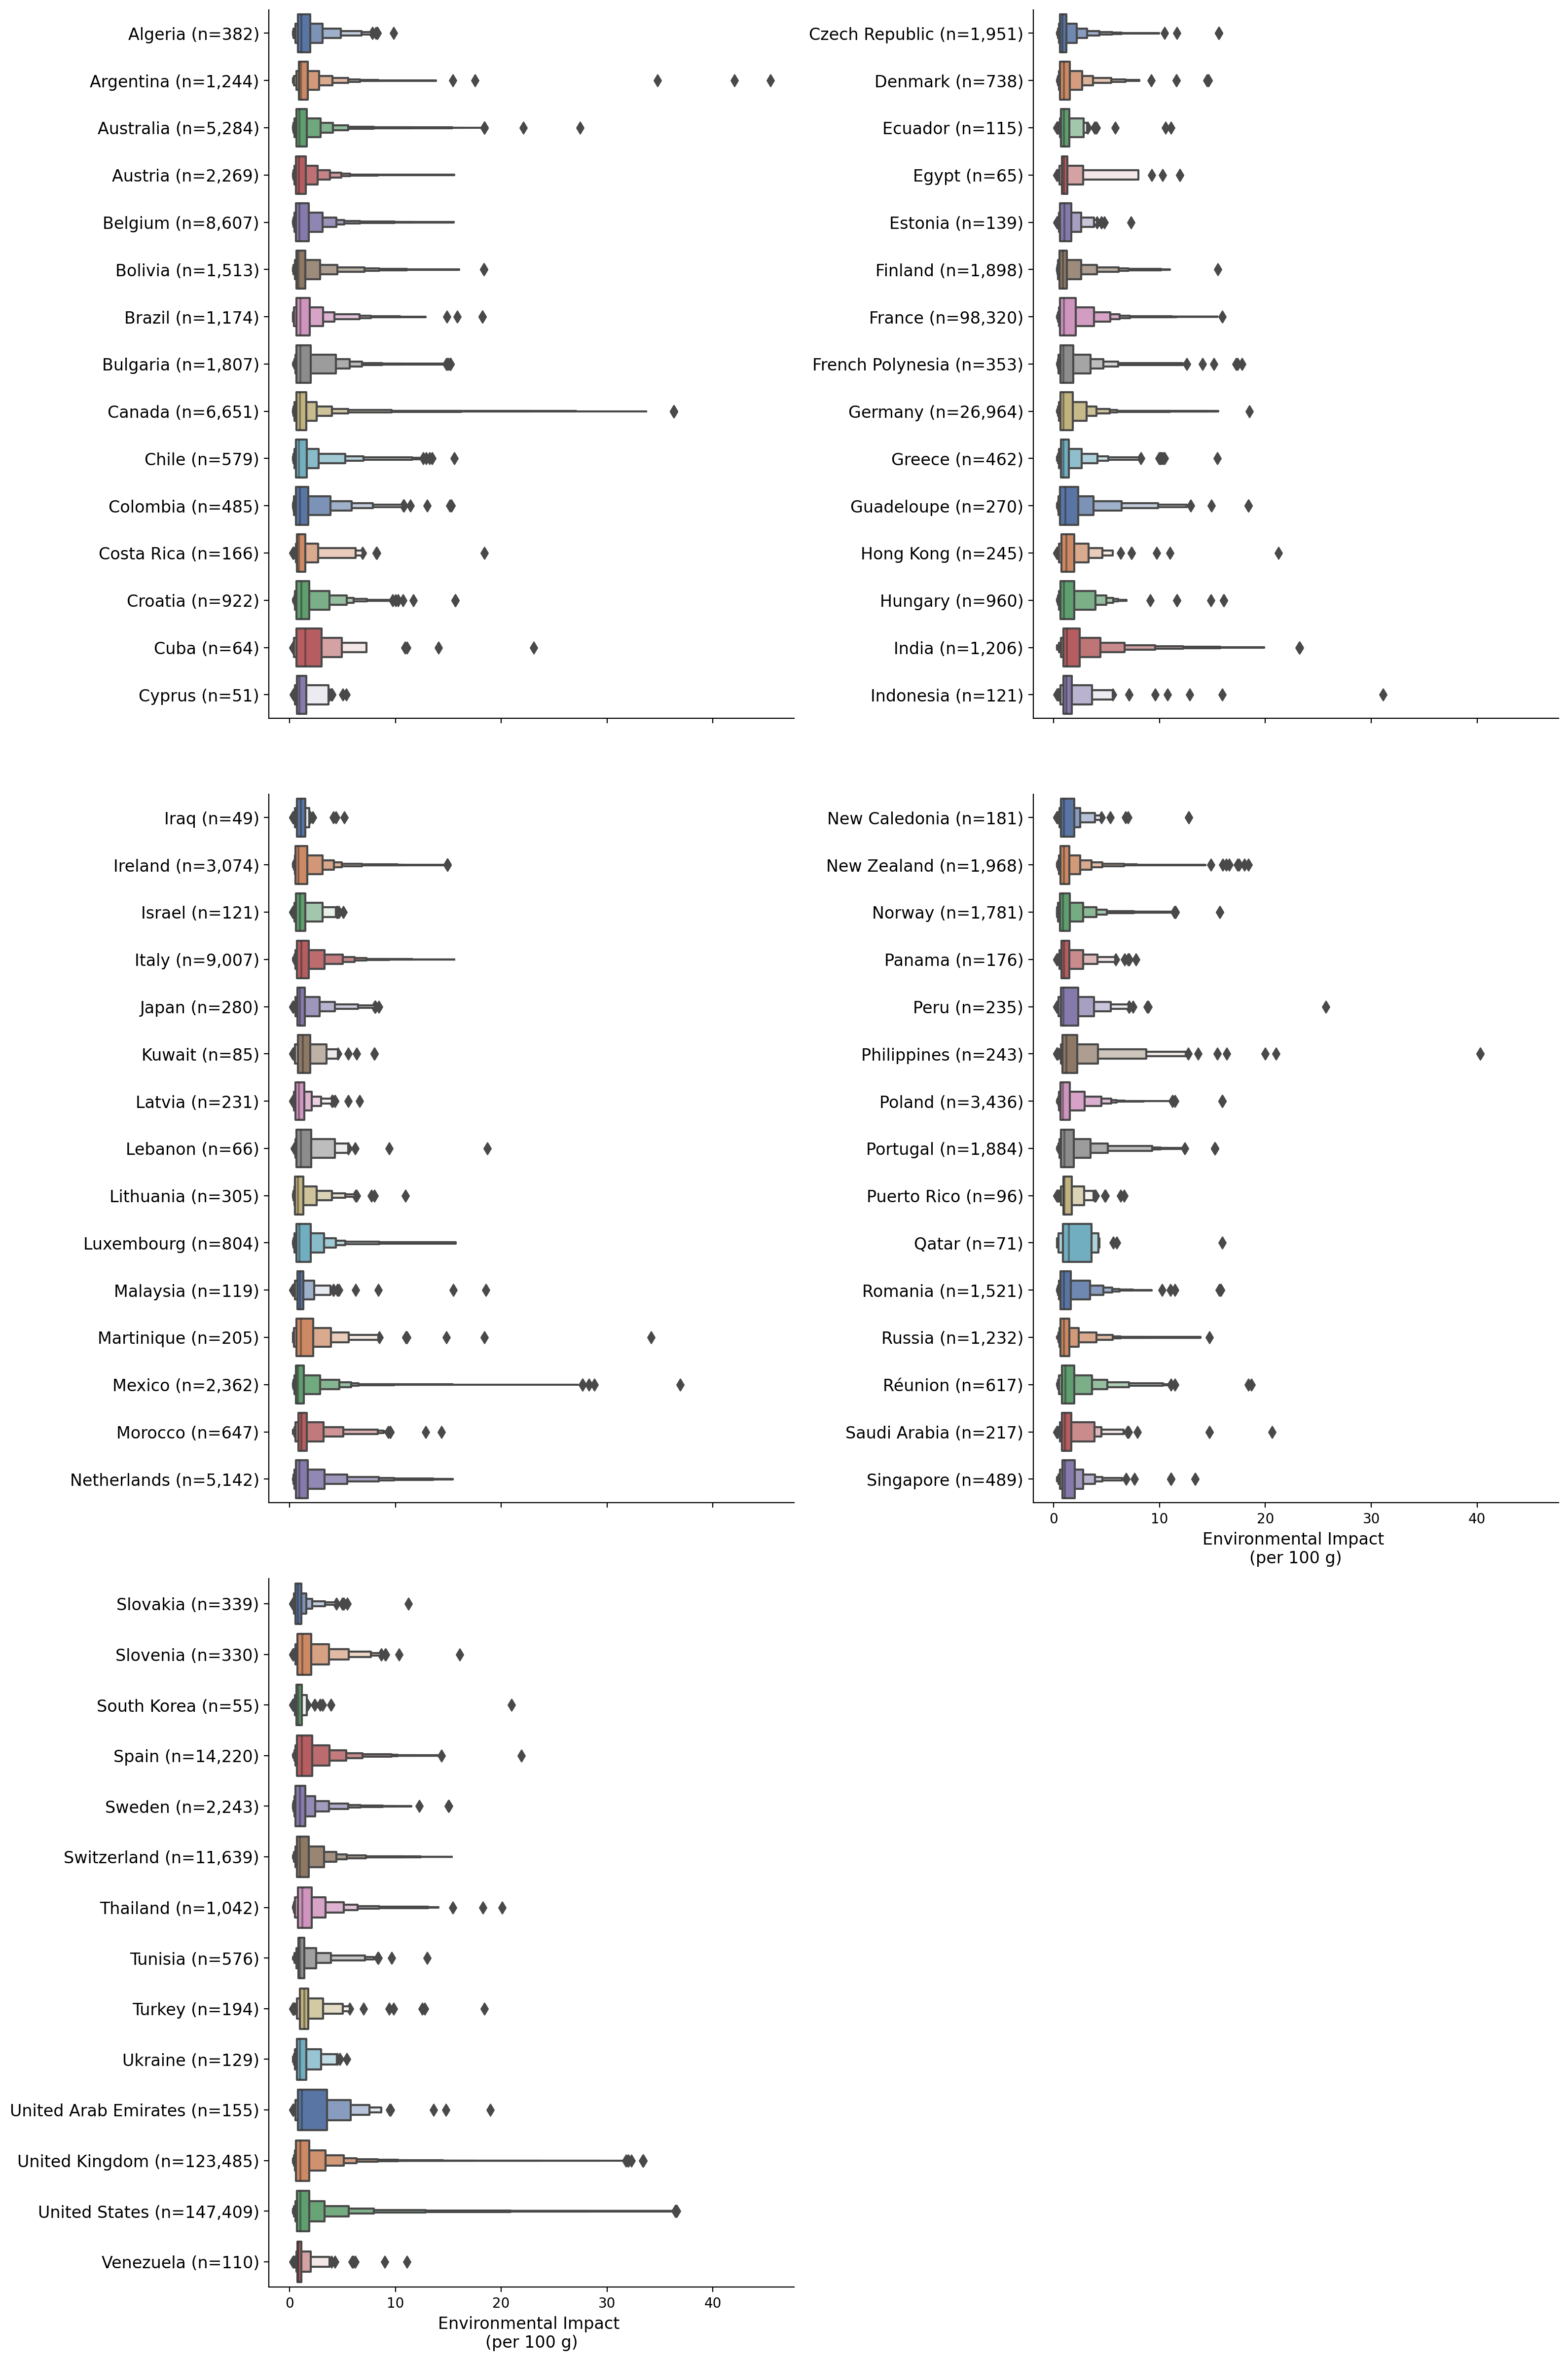

In [130]:
unique_countries = sorted(melted_df['country'].unique())
n_per_facet = 15
country_to_facet = {country: i // n_per_facet for i, country in enumerate(unique_countries)}
melted_df['facet'] = melted_df['country'].map(country_to_facet)
country_counts = melted_df['country'].value_counts()

g = sns.catplot(
    data=melted_df,
    kind="boxen",
    x="mean_norm",
    y="country",
    col="facet",
    col_wrap=2,  
    palette="deep",
    sharex=True,  
    sharey=False,
    height=8
)

for ax in g.axes.flat:
    ax.set_xlabel("Environmental Impact \n(per 100 g)", fontsize=12)
    ax.set_ylabel("")
    new_labels = []
    for label in ax.get_yticklabels():
        country = label.get_text()
        # Lookup the count; default to 0 if country is not found (shouldn't happen)
        count = country_counts.get(country, 0)
        # Format count with commas (e.g., 1,000)
        new_labels.append(f"{country} (n={count:,})")
    ax.set_yticklabels(new_labels, fontsize=12)
    
g.set_titles("")

plt.tight_layout()
plt.show()

#### nutrition stuff

In [267]:
nutri = pd.read_csv('../../SFS/environmental_impacts/Managed_Data/NutriScore for radar plots 2025-01-29 Log2.csv')

In [268]:
nutri = nutri.merge(melted_df.drop('country', axis=1), left_on='id', right_on='product_id')
nutri['NutriScorePoints'] = 100 * (nutri['NutriScorePoints'] - nutri['NutriScorePoints'].min()) / (nutri['NutriScorePoints'].max() - nutri['NutriScorePoints'].min())

In [269]:
nutri = nutri[(nutri['country'].isin(['France', 'United Kingdom', 'United States']))
             & (nutri['labels']!='mis')]

In [303]:
df = nutri.groupby(['country', 'groups', 'labels', 'ID'])[['mean_norm', 'NutriScorePoints']].mean().reset_index()

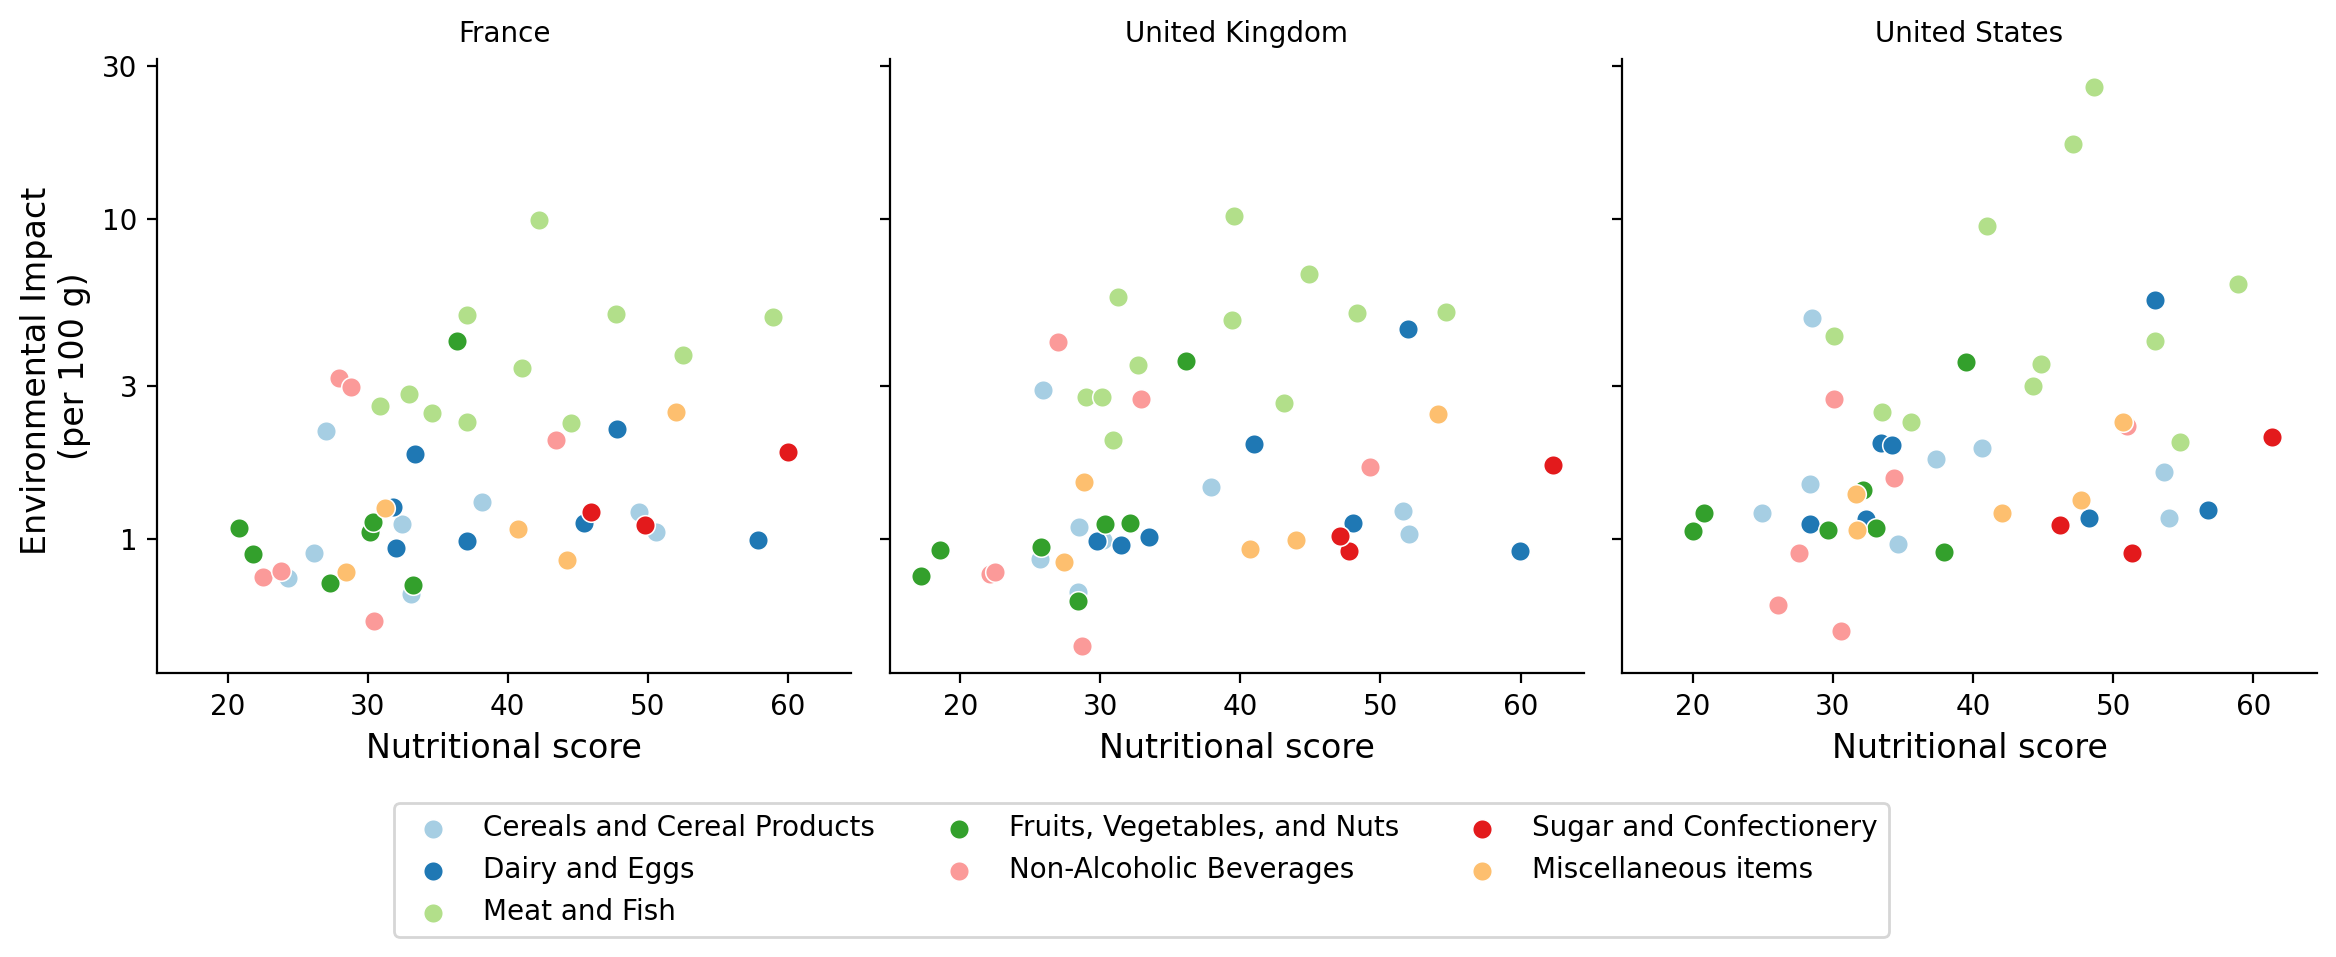

In [305]:
g = sns.FacetGrid(data=df, 
                  col="country",  hue='groups', 
                  hue_order=['Cereals and Cereal Products', 'Dairy and Eggs',
                             'Meat and Fish', 'Fruits, Vegetables, and Nuts',
                             'Non-Alcoholic Beverages', 'Sugar and Confectionery', 'Miscellaneous items'],
                  height=4, aspect=1,
                  palette="Paired")
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=50)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=12)
g.set_xlabels("Nutritional score", fontsize=12)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.1), frameon=True)

plt.show()

In [306]:
df = nutri.groupby('labels').apply(lambda g: g.sample(100)).reset_index(drop=True)

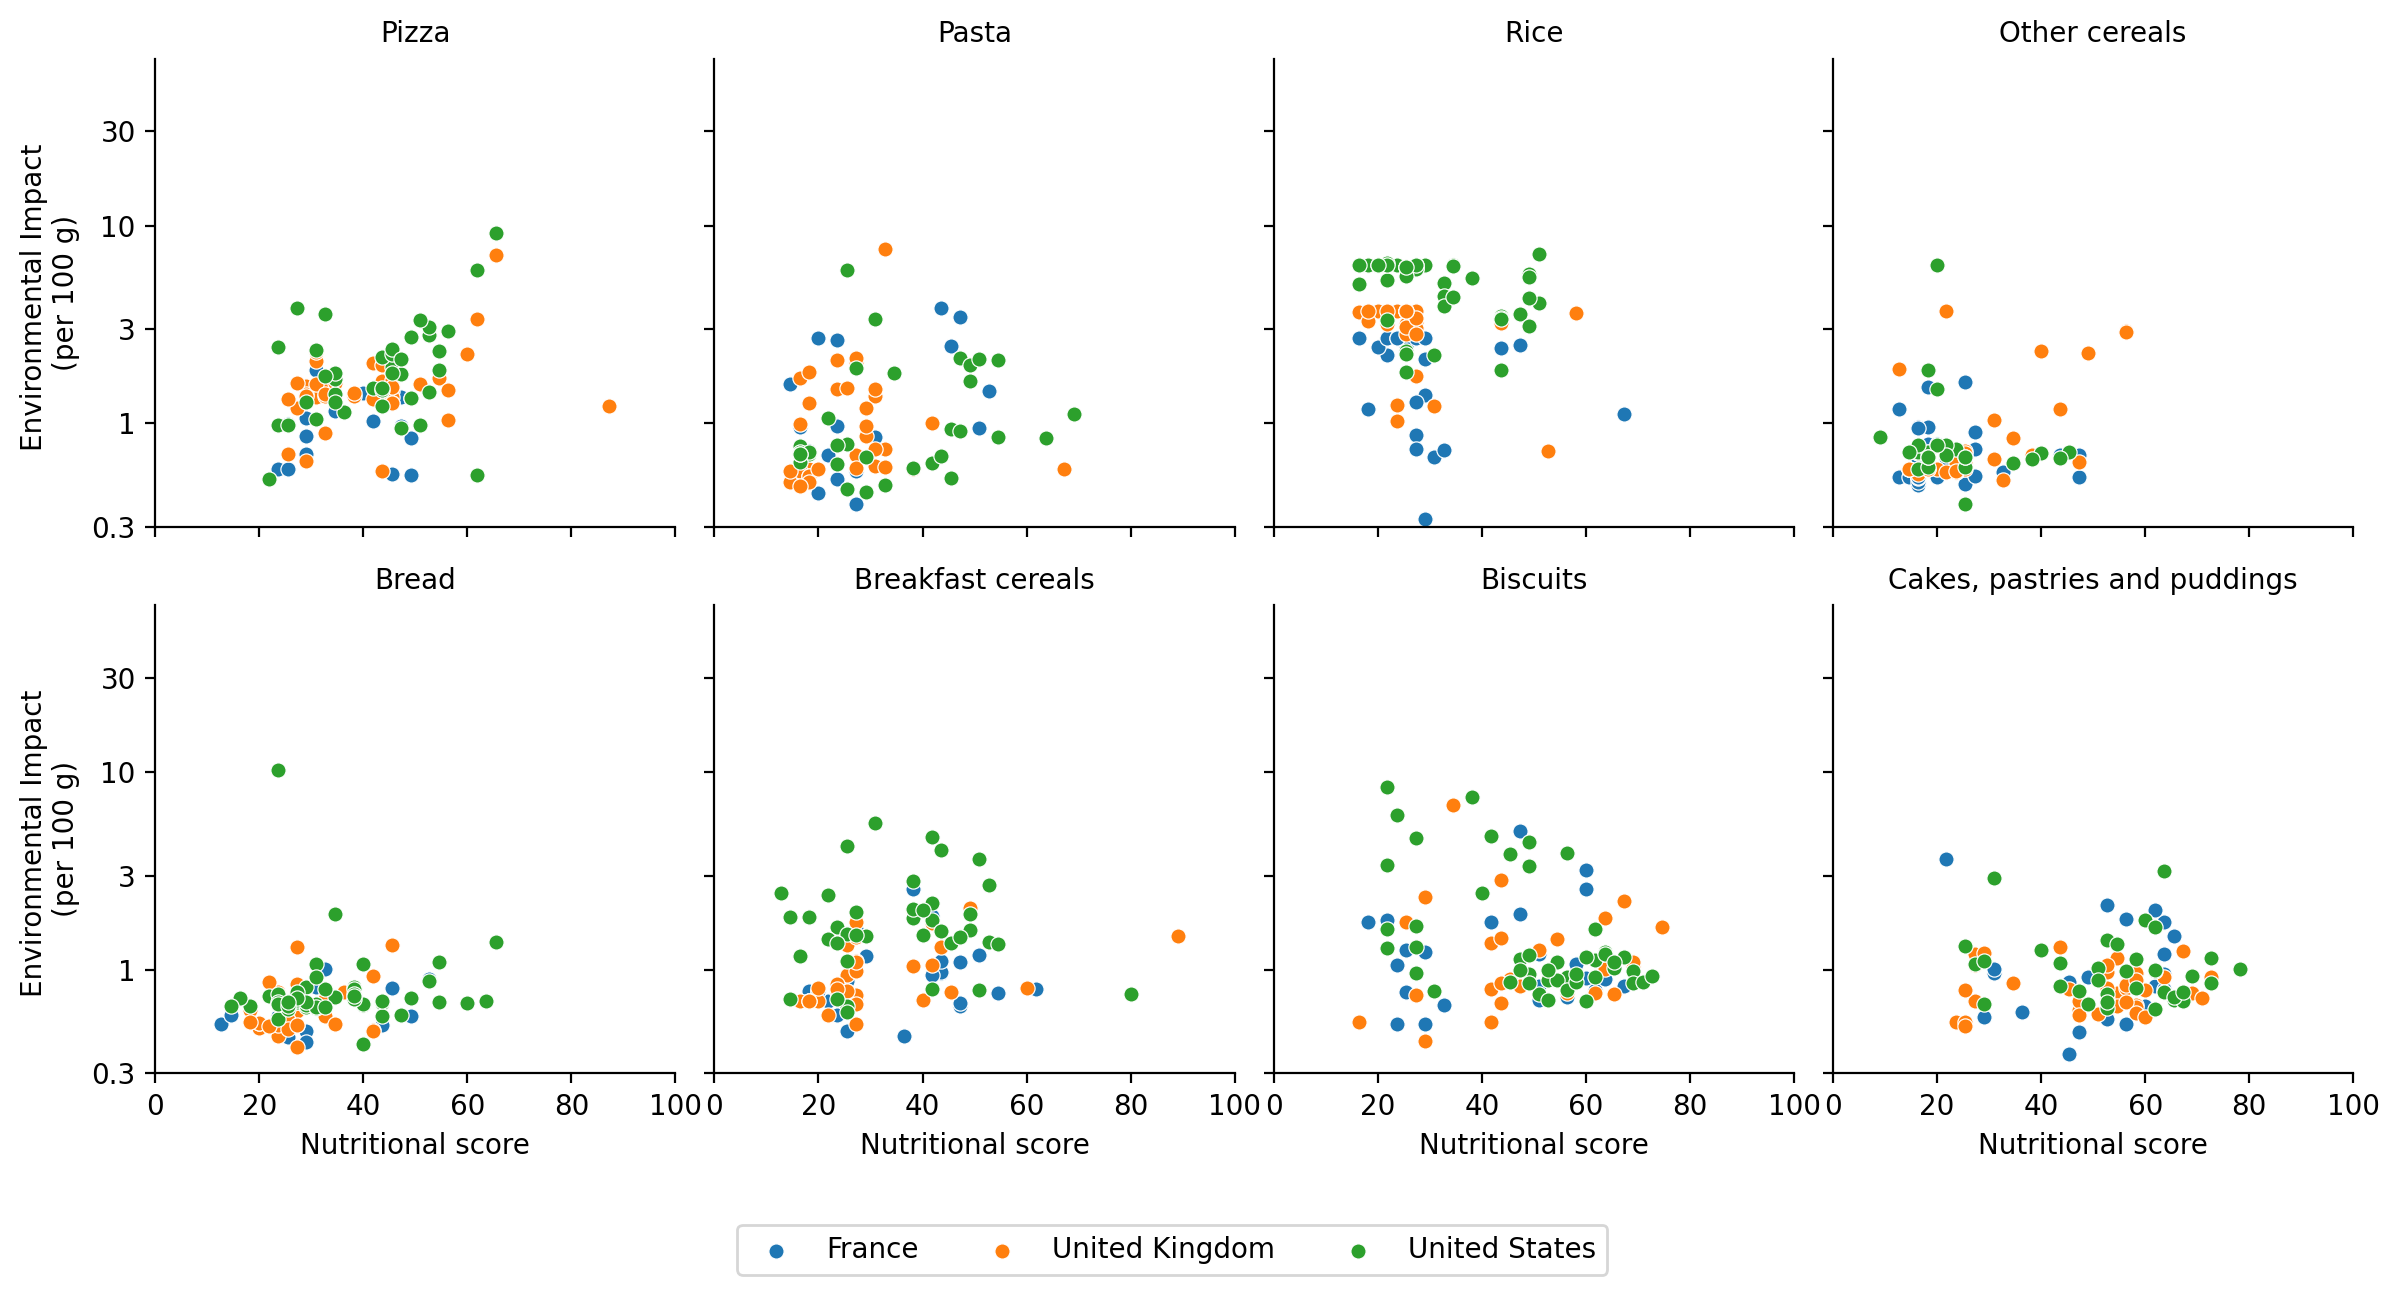

In [335]:
g = sns.FacetGrid(data=df[df['groups']=='Cereals and Cereal Products'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

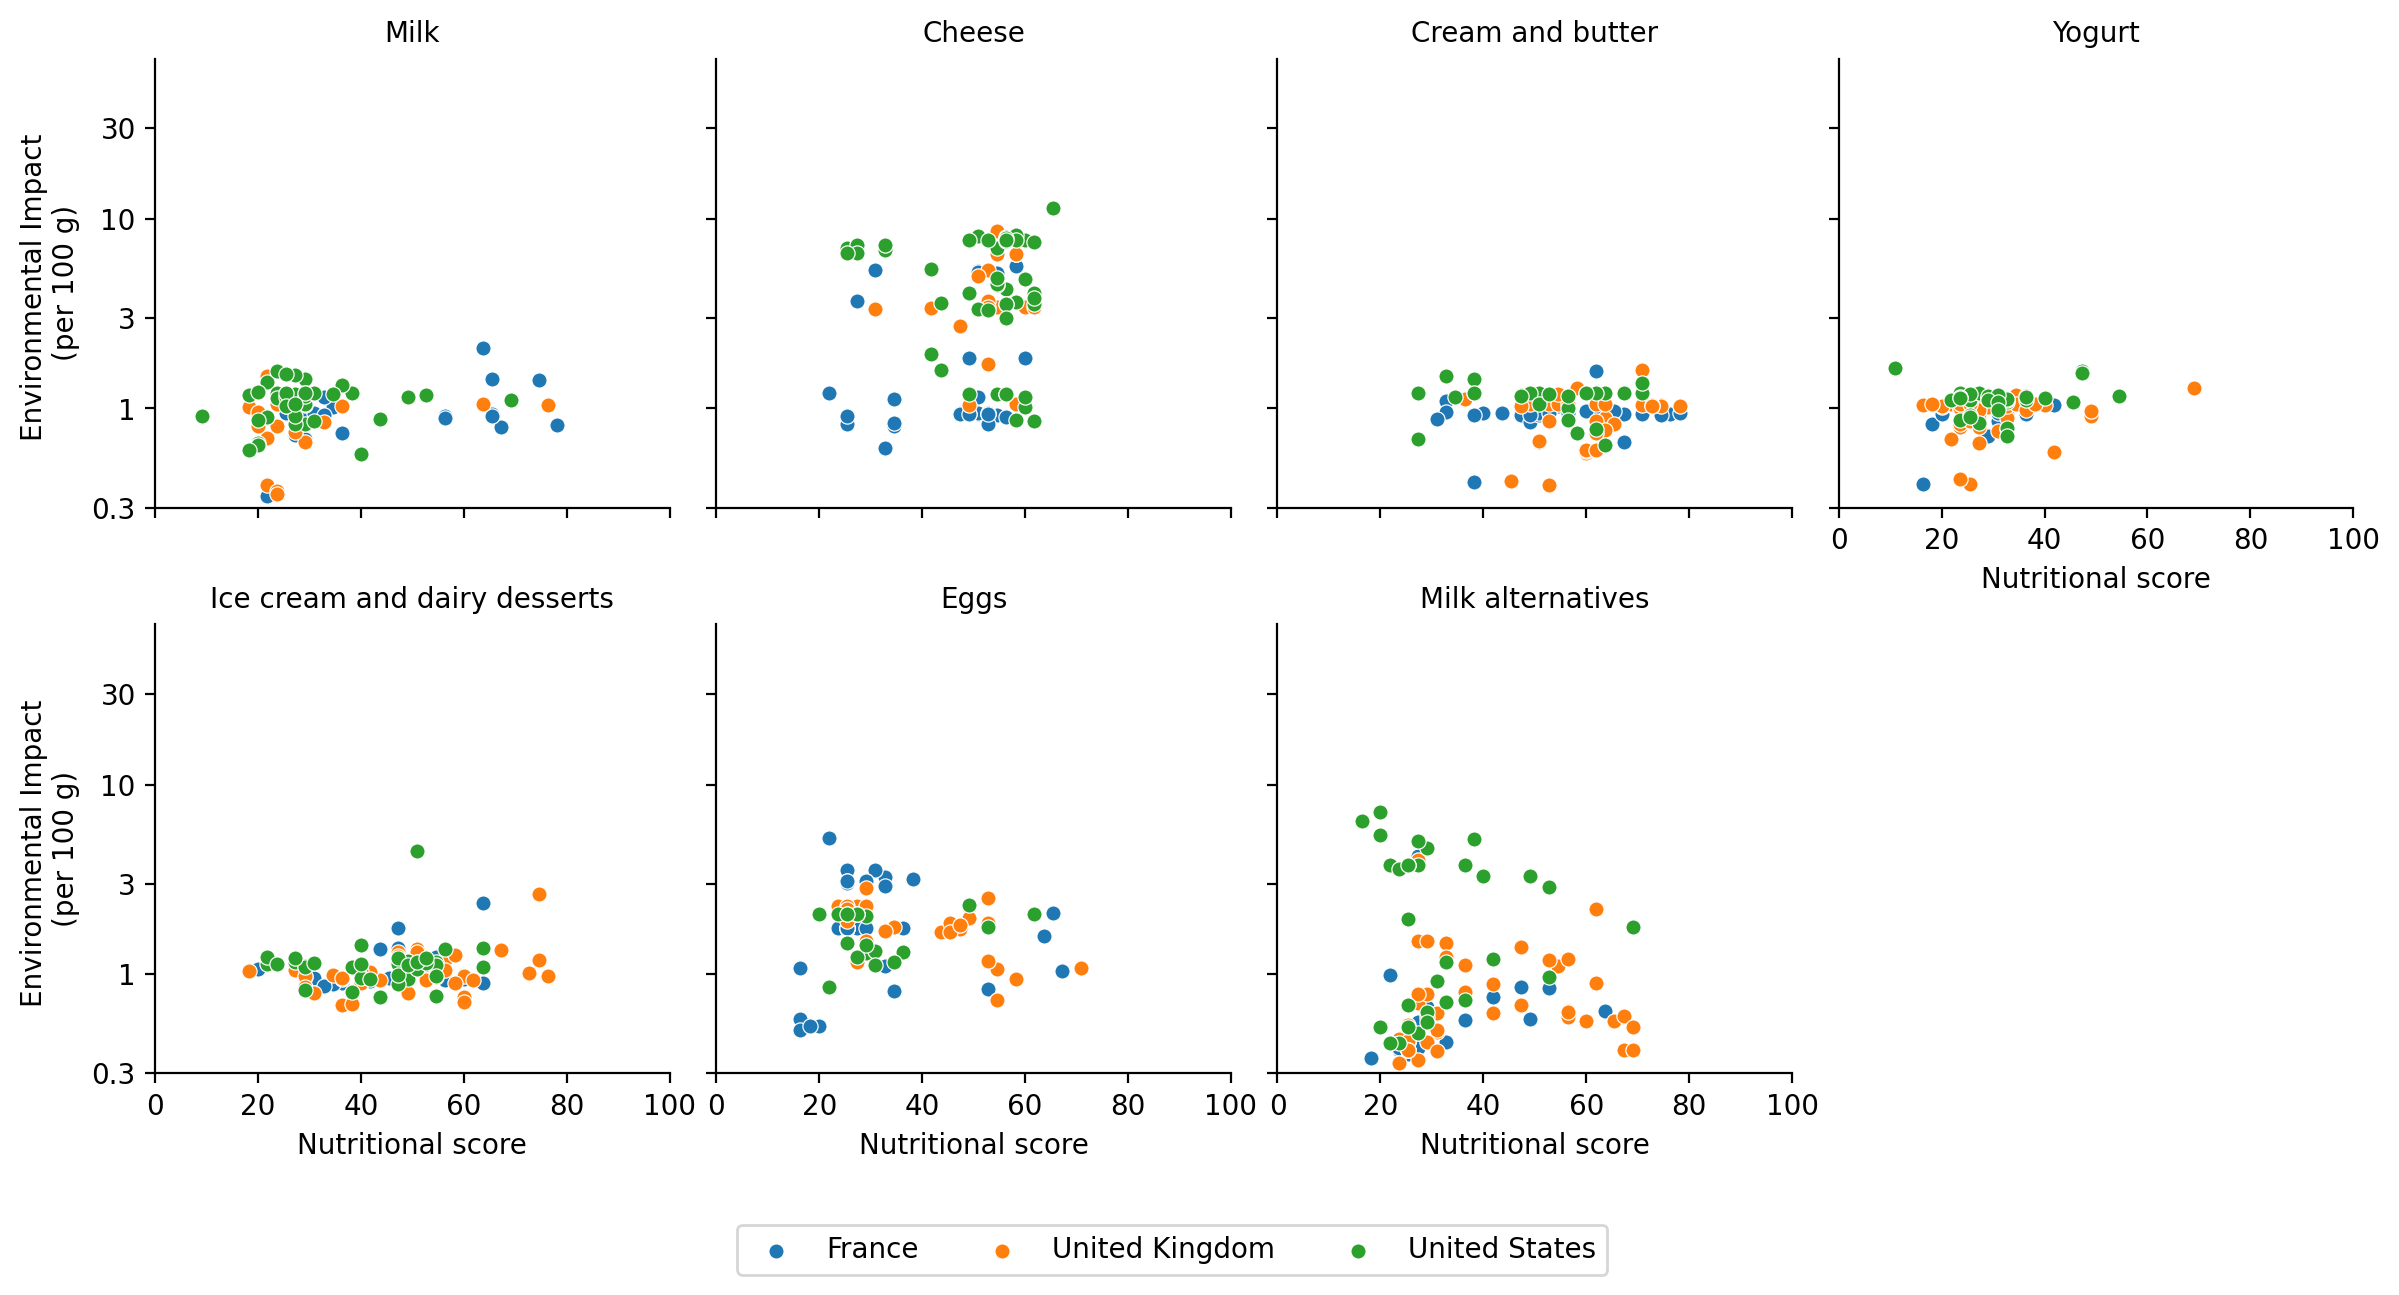

In [336]:
g = sns.FacetGrid(data=df[df['groups']=='Dairy and Eggs'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

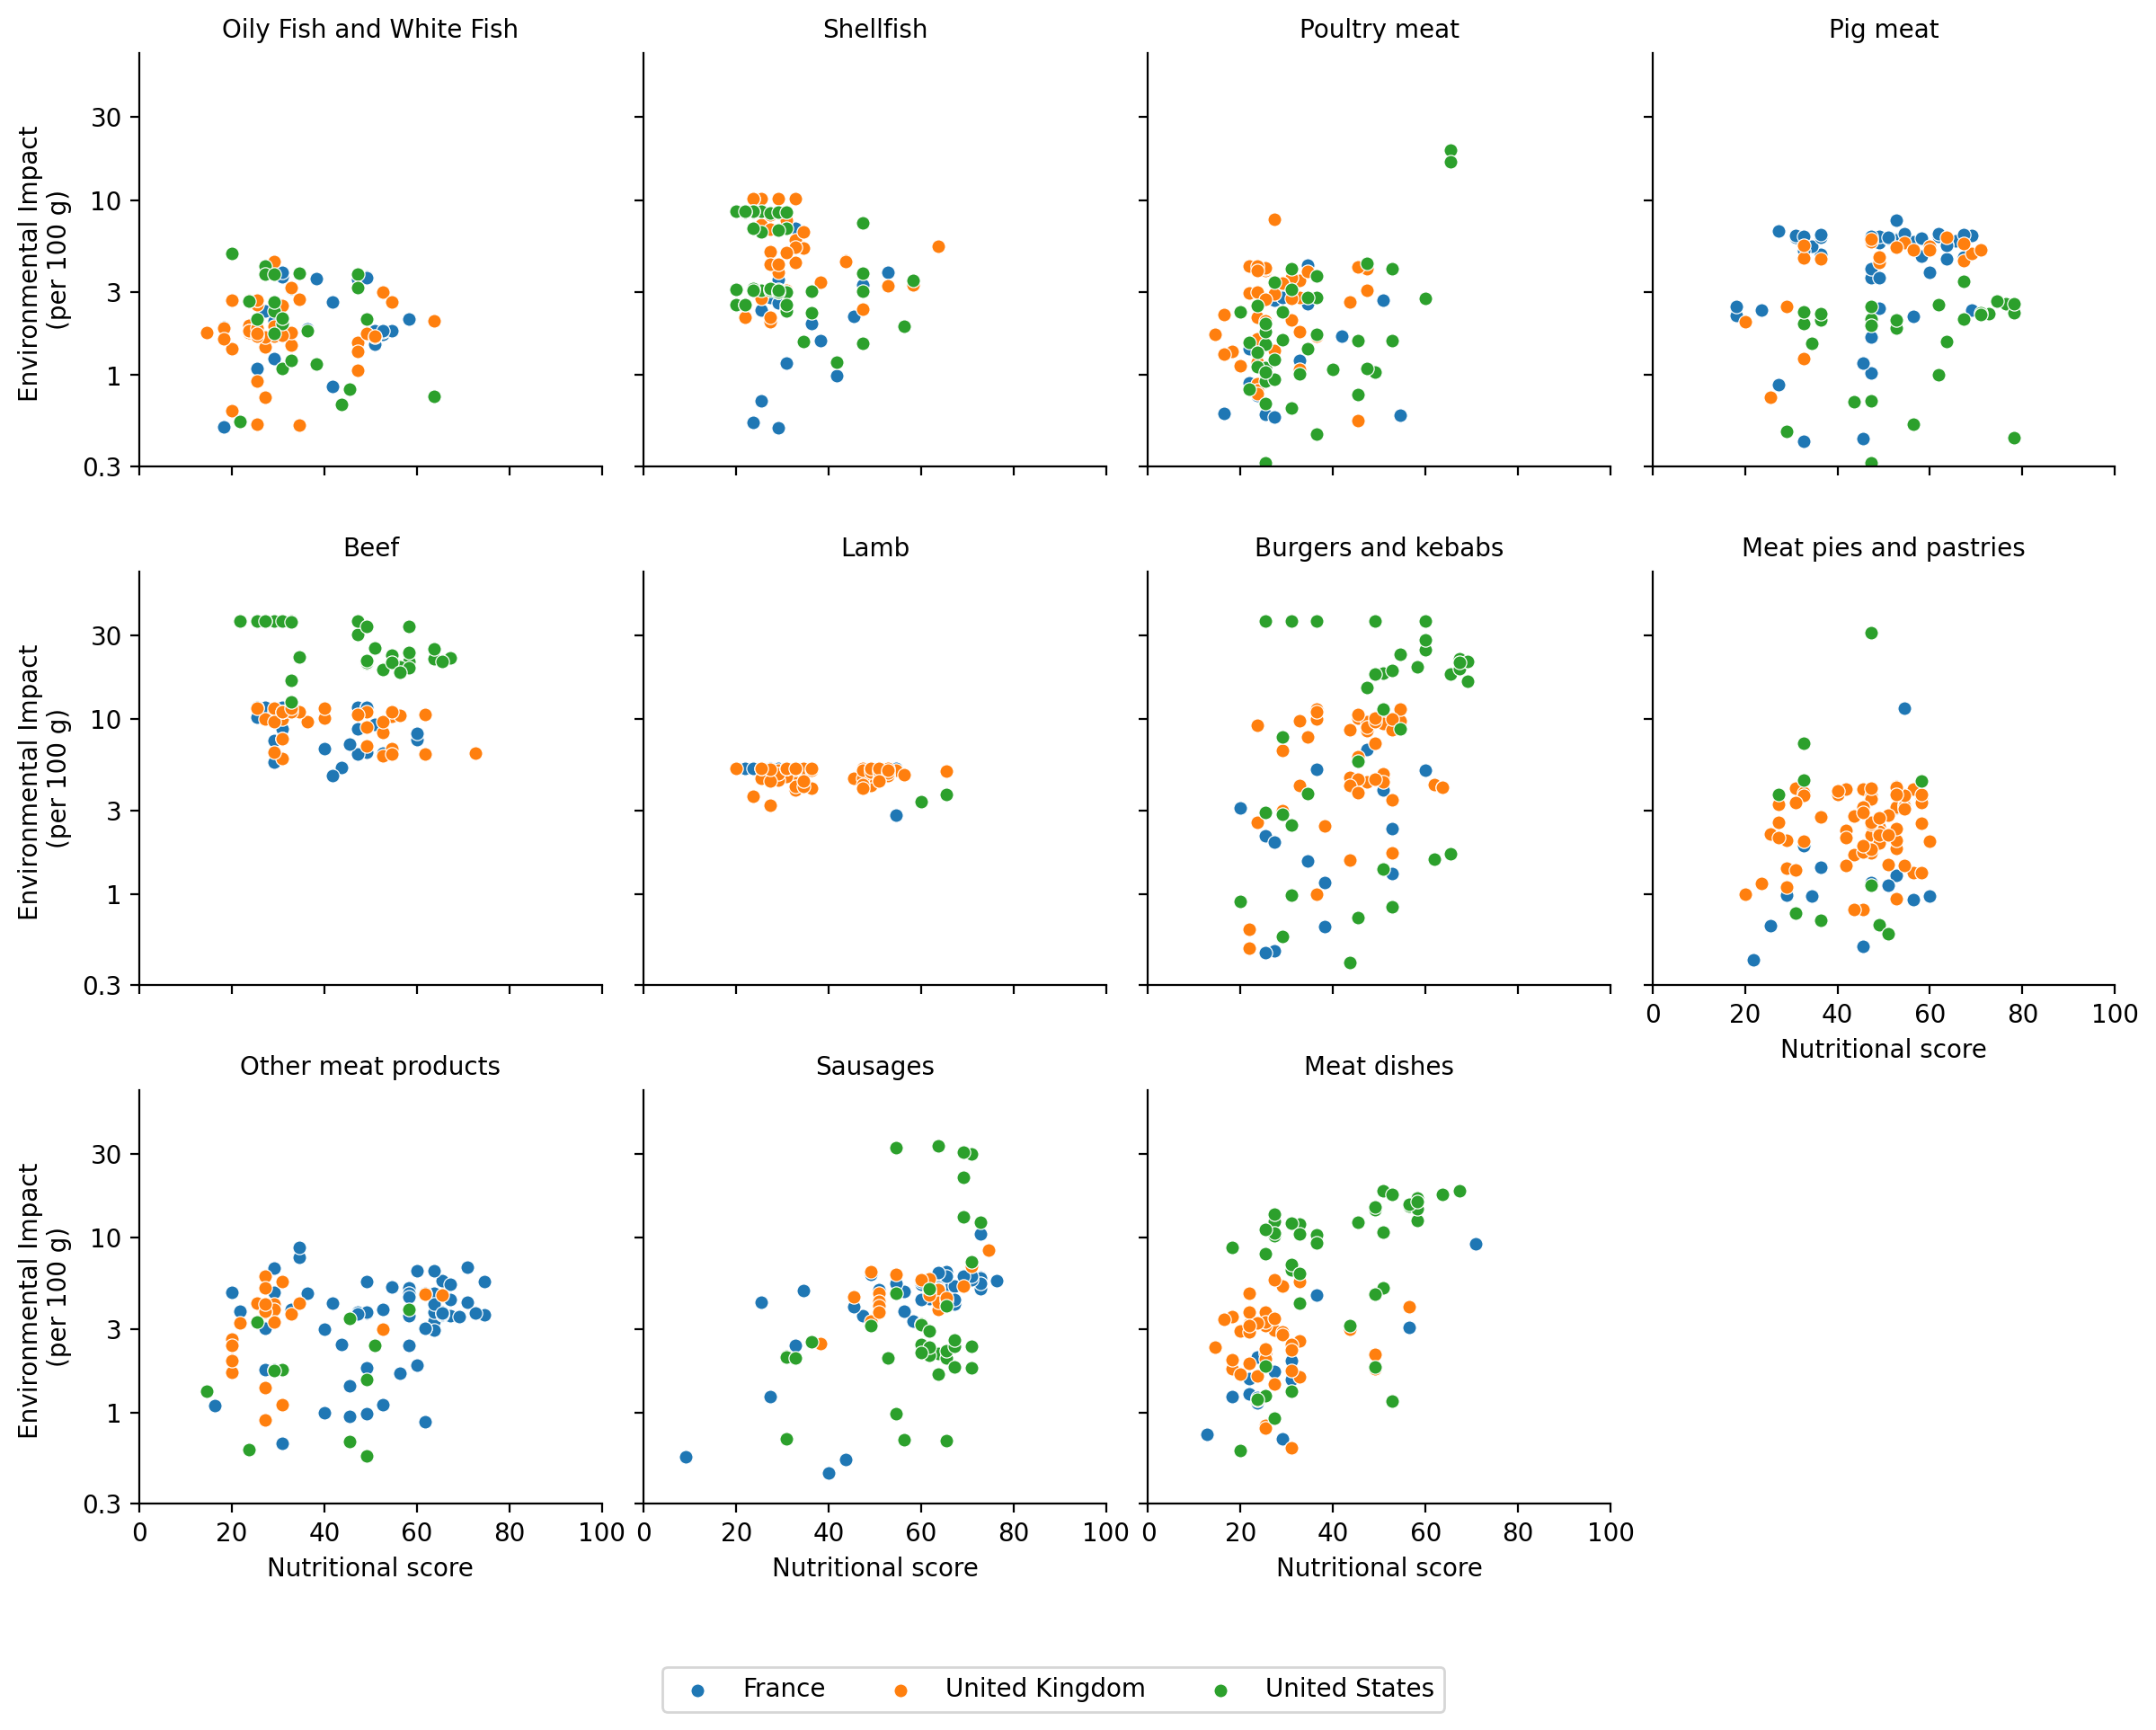

In [337]:
g = sns.FacetGrid(data=df[df['groups']=='Meat and Fish'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

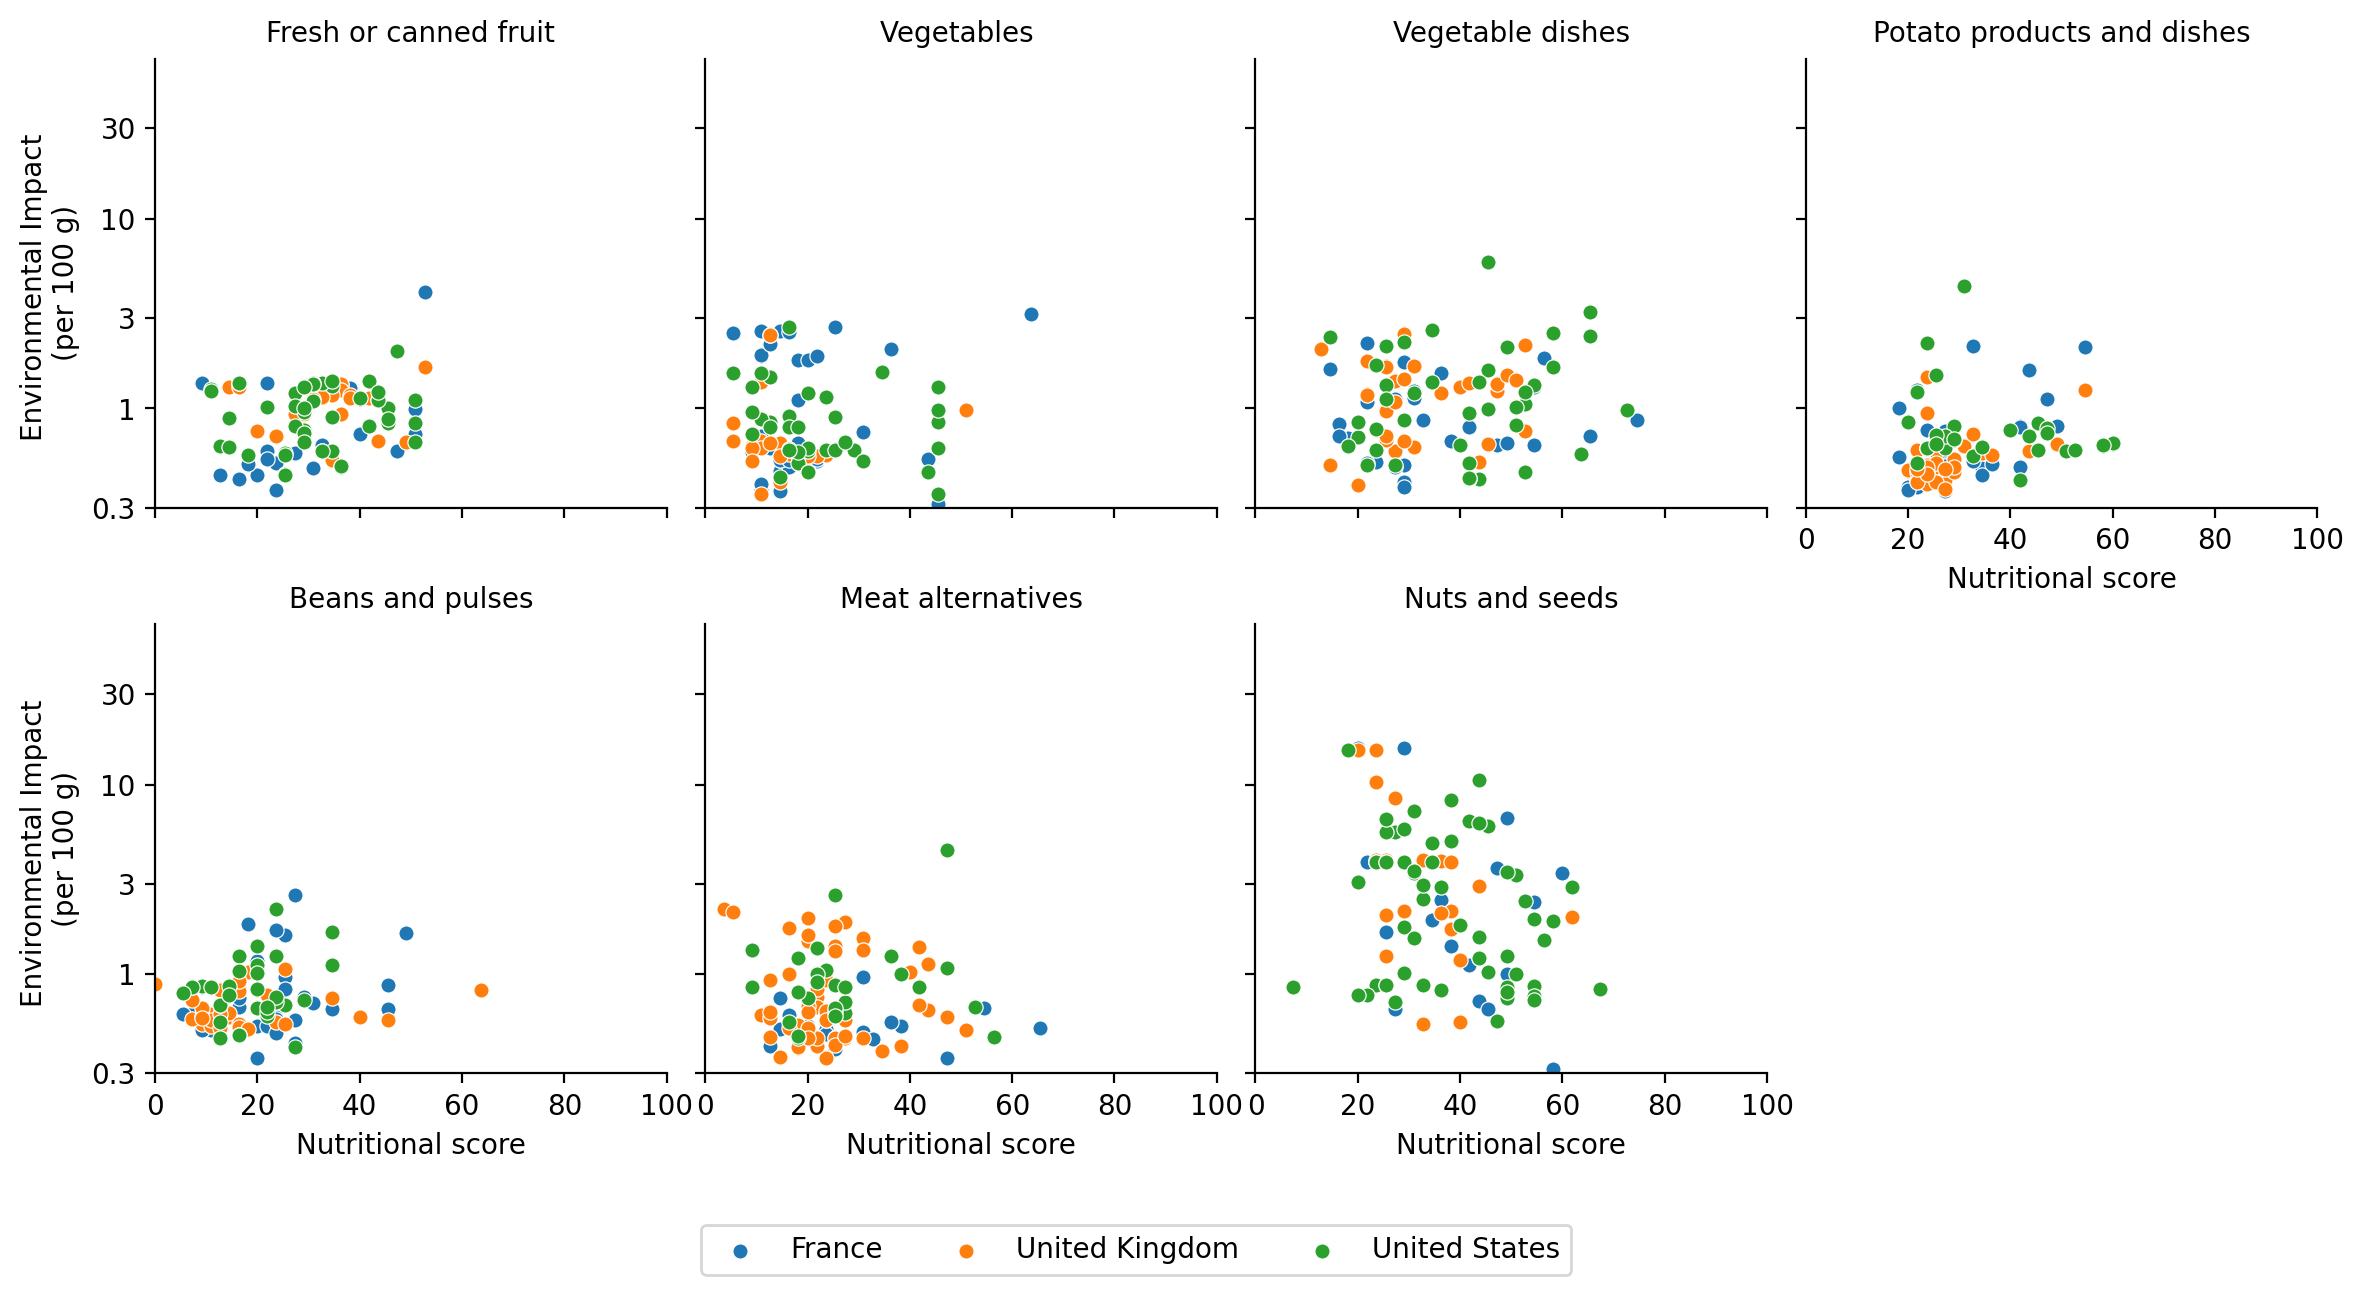

In [338]:
g = sns.FacetGrid(data=df[df['groups']=='Fruits, Vegetables, and Nuts'].sort_values(by='ID'), 
                  col="labels", hue='country',
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

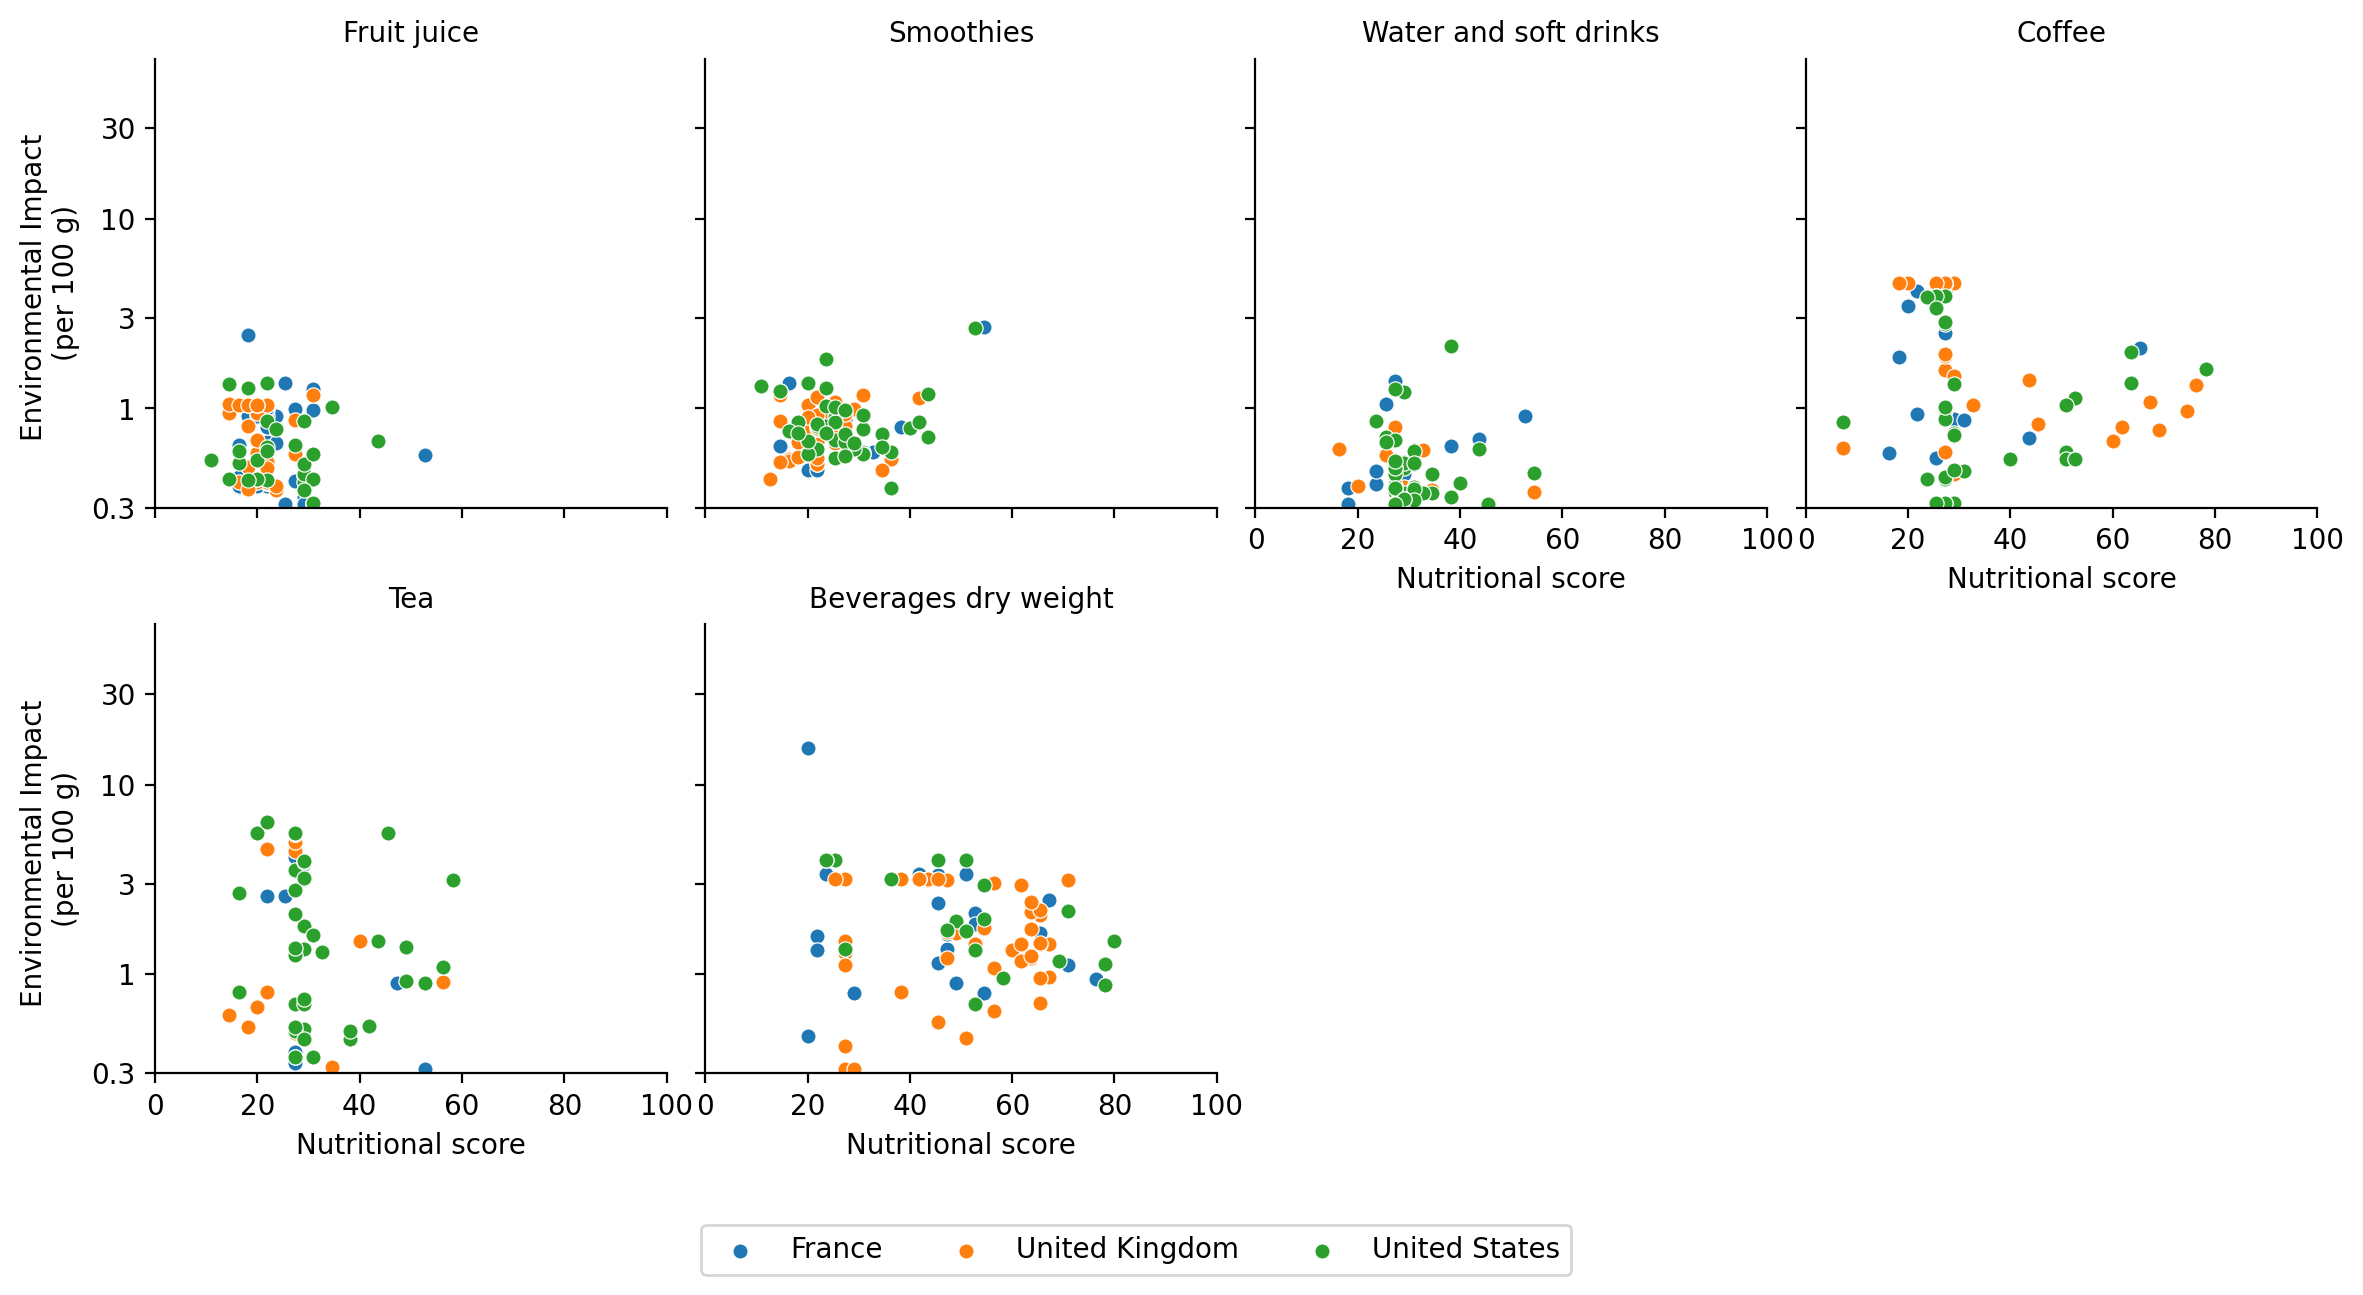

In [339]:
g = sns.FacetGrid(data=df[df['groups']=='Non-Alcoholic Beverages'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

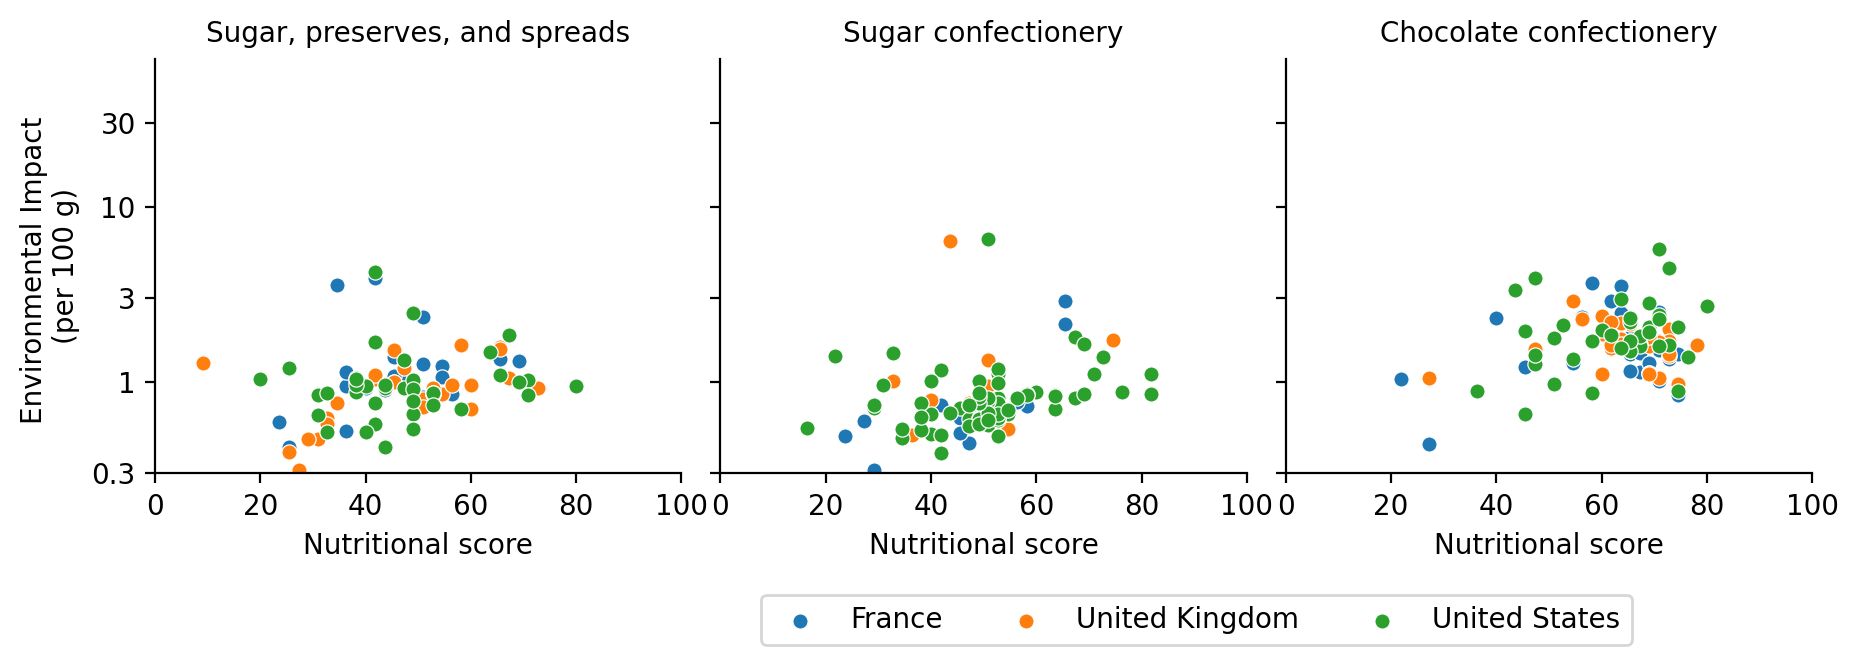

In [340]:
g = sns.FacetGrid(data=df[df['groups']=='Sugar and Confectionery'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

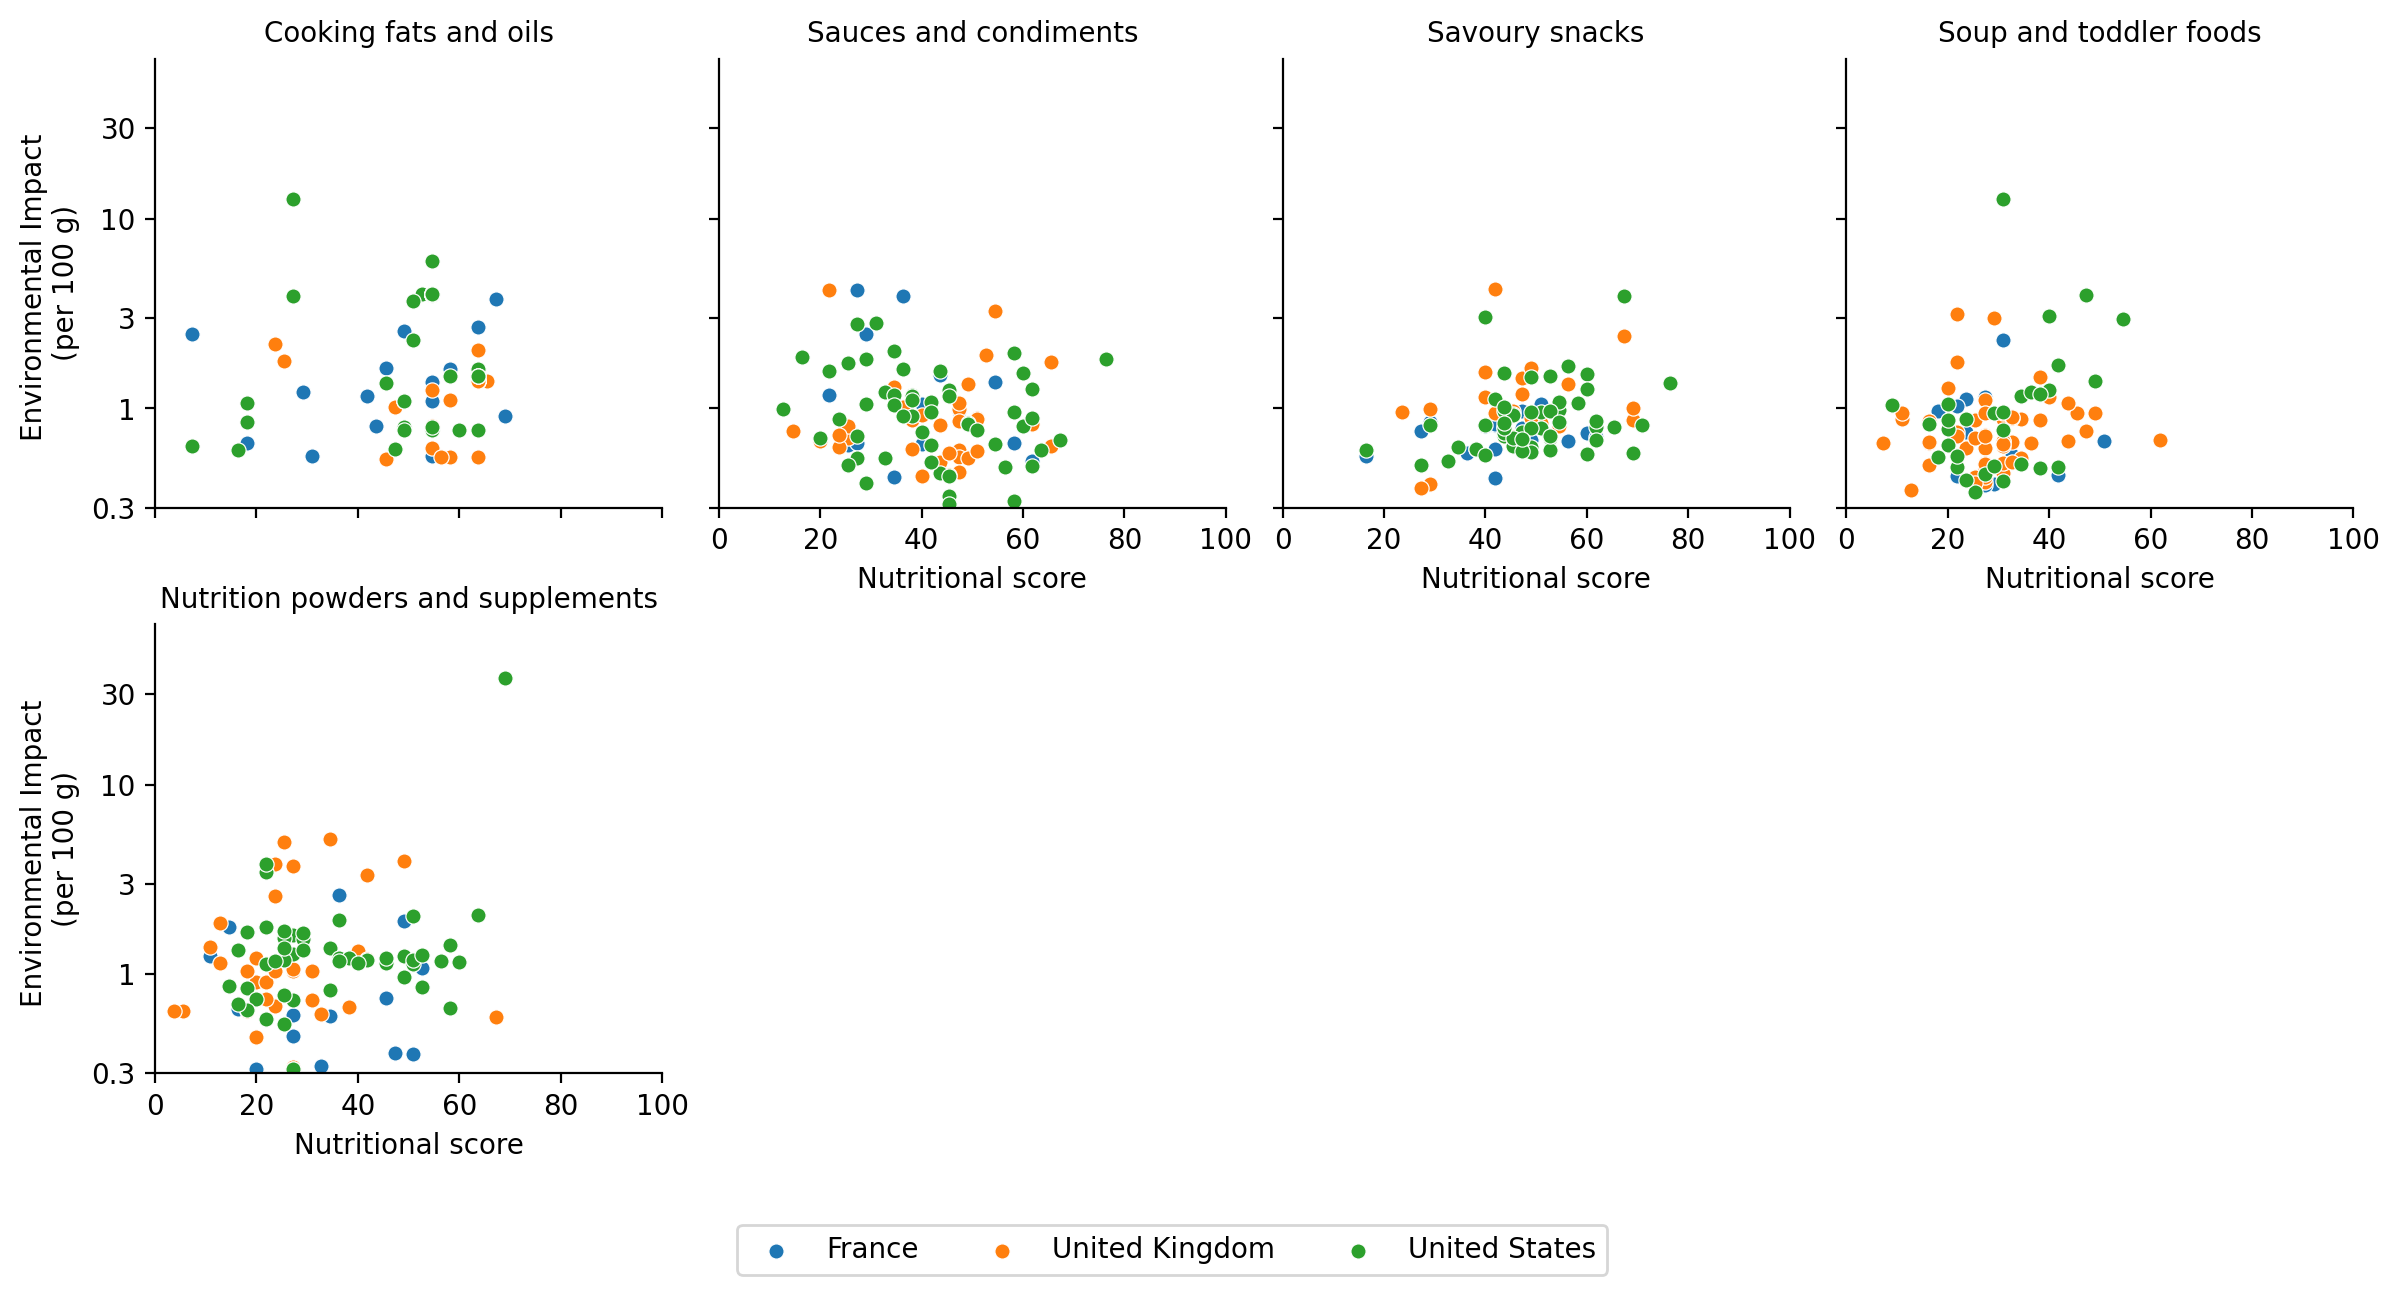

In [341]:
g = sns.FacetGrid(data=df[df['groups']=='Miscellaneous items'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()